In [1]:
from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
print(matplotlib.__version__)

3.9.0


In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/scratch/local/u1371365/998113/ipykernel_2680664/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [5]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [6]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0

In [7]:
from filehandling import get_ca_res, get_madgics_res, get_medres


In [8]:
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude


In [9]:
from MCMCfns import logprob_2


In [10]:
from sightline import Sightline


In [11]:
import time

In [12]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [13]:
lambda0 = 15272.42
from specfns import get_wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [14]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    # print(len(selection))
    selected_inds.append(selection)

91
23
28


In [15]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

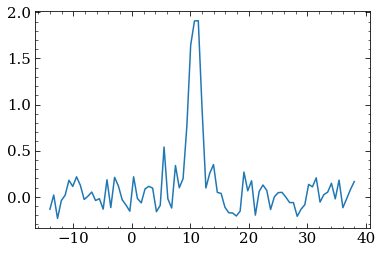

In [16]:
pathCO = '/uufs/astro.utah.edu/common/home/u1371365/Data/Temporary/Catalogs/DHT21_Taurus_interp.fits'
hdulCO = fits.open(pathCO)

headerCO = hdulCO[0].header
dataCO = hdulCO[0].data
wcsCO = WCS(headerCO)

glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

l, b, v = np.meshgrid(glon, glat, rvel)
coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
                  pm_b = 0 * u.deg /u.s, distance = 500 * u.pc, frame = 'galacticlsr')

coord_icrs = coord.transform_to('icrs')

def get_CO_profile(l, b):
    coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
    pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
    CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
    rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
    return CO_profile, rvel
profile, rvel = get_CO_profile(165, -7)

plt.plot(rvel, profile)

In [17]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 3):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2) #+ medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [18]:
print('test')

test


In [19]:
from spacefns_v2 import dAV_dd_array
from residual_process import reprocess
from filehandling import getASPCAP, getapStar

class ForegroundModifiedSightline(Sightline):
    def __init__(self, stars, coords = None, dAVdd = None, dfore = 400, **kwargs):
        # self.all_stars = stars
        self.stars = stars[stars['DIST'] > dfore]
        dist = self.stars['DIST']

        self.make_fgbins()
        self.bin_inds = np.digitize(dist, self.bins)

        if coords is not None:
            self.l, self.b = coords
        else:
            self.l, self.b = (np.nanmean(self.stars['GLON']), np.nanmean(self.stars['GLAT']))
        
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)

        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)

        self.test_init_signals = self.model_signals_fg(self.rvelo, self.dAVdd)
    
    def get_DIBs(self, MADGICS = False, alternative_data_processing = None, **kwargs):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)

        if alternative_data_processing is not None:
            # needs to take aspcap, medres, apstar, rv as arguments
            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                aspcap = fits.open(getASPCAP(star))
                apstar = fits.open(getapStar(aspcap))
                medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
                sig, err = alternative_data_processing(aspcap, medres, apstar, star_rv)
                signals[i, :], signal_errs[i, :] = sig[window], err[window]

               
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)
        
        else:
            if MADGICS:
                signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
                signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))

            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                res_hdul = fits.open(get_ca_res(star['FILE']))
                signals[i, :] = res_hdul[1].data[window]
                signal_errs[i, :] = res_hdul[2].data[window]
                reprocess_uncertainty = True
                if reprocess_uncertainty:
                    signal_errs[i, :] = self.reprocess_errs(res_hdul, star['VHELIO_AVG'])[window]
                reprocess_residual = True
                if reprocess_residual:
                    res_repr, err_repr = reprocess(res_hdul, star['VHELIO_AVG'])
                    signals[i, :] = res_repr[window]
                    signal_errs[i, :] = err_repr[window]
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)

                if MADGICS:
                    signals_aspcap[i, :] = np.copy(signals[i, :])
                    signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                    res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                    signals[i, :] = res_hdul_m[1].data[0, 125:][window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap

    def make_fgbins(self, binsep = 10, dfore = 400, **kwargs):
        dmin = 0 # start bins at 0pc
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), [0,1], [dmin, dfore]))
        # print('BINS BEFORE THING', bins)
        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins

    def model_signals_fg(self, rvelo, dAVdd=None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins)-1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals


In [20]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(ForegroundModifiedSightline(CA_meta[selected_inds[i]], dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/scratch/local/u1371365/998113/ipykernel_2680664/3305682505.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch/local/u1371365/998113/ipykernel_2680664/3305682505.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [21]:
sightlines = sightlines[:15]

In [22]:
from MCMCfns import logprob_fg, Logprior_Foreground

# def logprob_2(p, sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs): ## NEW AS OF 05.16LIke.
#     ndim = len(sl.voxel_dAVdd)
#     v = p[ :ndim]
#     av = p[ndim:].reshape(-1, ndim)
#     lp = logprior(v, **kwargs)
#     lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
#     lp_davdd_reg = 0.0 # logprior_davdd_reg(av, sl, **kwargs)
#     lp_davdd_reg_group = 0.0. logprior_davdd_reg_group(av, sl)
#     if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
#         return -np.inf
#     return lp + lp_davdd  + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs) + lp_davdd_reg_group # group term added 10.13


# def logprob_fg(p, sl, lp_fore = None, **kwargs):
#     ndim = len(sl.voxel_dAVdd)
    
#     lprob = logprob_2(p, sl, **kwargs)
#     v = p[ :ndim]
#     av = p[ndim:].reshape(-1, ndim) #what shape is dAVddd? 

#     ### Added 05.08 ###
#     lprior_av_min = logprior_davdd_min(av)
#     lprob = lprob + lprior_av_min

#     lp_fore_v = lp_fore.logprior_foreground_v(v, sl.bins[1:])
#     # lp_fore_av = lp_fore.logprior_foreground_av(av, sl.bins[1:])
#     return lprob + lp_fore_v #+ lp_fore_av


def MCMC_fg(sl, steps = 1000, nwalkers = 100, pool = None, filename = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)

    lp_foreground = Logprior_Foreground(sl.l, sl.b)

    
    if filename is not None:
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim_amp)
    else:
        backend = None
    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_fg, 
                                    kwargs={'sl': sl, 'lp_fore': lp_foreground}, pool = pool, backend = backend) # OKAY SO I FORGOT TO CHANGE THIS, WAS LOGPROB_2
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
    init[:, ndim:] 
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True, );
    
    return sampler, ndim, ndim_amp

In [23]:
sl = sightlines[0]
ndim = len(sl.voxel_dAVdd) 
nstar = len(sl.stars)
ndim_amp = int(ndim + ndim * nstar)
lp_foreground = Logprior_Foreground(sl.l, sl.b)
# lp_foreground.logprior_foreground_v(10, 400)

In [24]:
init = 10 *  (np.random.random((500, ndim_amp)) - 0.5)
init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
print(logprob_fg(init[5, :], sl, lp_fore = lp_foreground,))

-776.9033420279294


In [25]:
sl.bins[1:].shape
sl.dAVdd.shape

(4, 5)

In [26]:
print('ndim', sl.ndim)
print('nsig', sl.nsig)
print('signals shape', sl.signals.shape)
print('dA(V)/dd shape', sl.dAVdd.shape)
print('dA(V)/dd shape in logprob fn', sl.dAVdd.flatten().reshape(-1, sl.ndim).shape)

ndim 5
nsig 4
signals shape (4, 95)
dA(V)/dd shape (4, 5)
dA(V)/dd shape in logprob fn (4, 5)


In [27]:
sl.dAVdd

array([[1.42089844, 0.02955627, 0.90771484, 0.        , 0.        ],
       [1.27929688, 0.03353882, 0.8828125 , 0.05215454, 0.00683594],
       [1.296875  , 0.02853394, 0.96777344, 0.05532837, 0.        ],
       [1.08691406, 0.02635193, 0.        , 0.        , 0.        ]])

In [28]:
'ready'

'ready'

In [29]:
stp = 1250
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sTHIsTThisterasdfdsfafsdfsdafampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

if False:
    today = str(datetime.date.today()).split('-')
    datelabel = today[1]+today[2]
    run_label = 'kt_' + datelabel + 'a'
else:
    # run_label = 'kt_0513a' # BEST ONE STILL
    # run_label = 'kt_0530a'
    # run_label = 'kt_0601a' # in sigclip_3 
    run_label = 'kt_0531a' # in sigclip_3, use this


save_individual = False

first_run = False



if first_run:
    if not os.path.exists(os.getcwd() + 'RUNS_H5/240531_SIGCLIP_3/' + run_label):
        os.makedirs(os.getcwd() +'RUNS_H5/240531_SIGCLIP_3/' + run_label)
        inp = input('Please describe this run:')
        with open('RUNS_H5/240531_SIGCLIP_3/global_log.txt', mode = 'a') as global_log:
            global_log.write('-------------------------------------------- \n')
            global_log.write(run_label)
            global_log.write(inp + '\n \n')
    with Pool(10) as pool:
        for i in range(len(sightlines)):
            # try:
            if True:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_fg(sl_i, steps = stp, nwalkers = 500, pool = pool, filename = 'RUNS_H5/240531_SIGCLIP_3/'+run_label + 'sampler_{}.h5'.format(i))
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                
                sl_i.intake(smplr)
                state = 'success'
            # except Exception as e:
            #     print('Something went wrong')
            #     sl_i = None 
            #     state = 'fail'
            #     with open('RUNS_FG_SIGCLIP/' + run_label + '/FAILS.txt', mode = 'a') as fails:
            #         fails.write(str(e))
                
            with open('RUNS_H5/240531_SIGCLIP_3/' + run_label + '_LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS_FG_SIGCLIP/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)


In [30]:
name = None# run_label
# name 

# first_run = False

if False:
    # f = open('RUNS_H5/240531_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')
    f = open('RUNS_H5/240531_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')

    pickle.dump(sightlines, f )
    f.close()
else:
    # f = open('RUNS_FG_SIGCLIP/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')
    f = open('/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/RUNS_H5/240531_SIGCLIP_3/sightlines_kt_0602a.pickle', 'rb')
    sightlines = pickle.load(f)
    f.close()

In [31]:
class SamplerContainer:
    def __init__(self, sampler, ndim, ndim_amp):
        self.sampler = sampler
        self.ndim = ndim
        self.ndim_amp = ndim_amp

In [32]:
# 0517a: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 2
# 0517b: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 4
# 0517c: should be a normal kt run liike 0513a, first 20 sightlines. This should be my baseline, basically
# 0530a: maintains no Gaussian priors on extinction (other than the foreground. 5 sightlines, 1000 steps, 500 walkers


In [33]:
# fig, ax = plt.subplots()
# ax.plot(sightlines[0].sampler.chain[:, :, 0].T, color = 'k', alpha = 0.1)

In [34]:
def polynomial2d( x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        print(matrix.shape)
        return np.nansum(matrix, axis = 1).flatten()

def box(x, min = -8.5, max = 17.5):
     y = np.ones(len(x))
     y[x < min] = 0
     y[x > max] = 0
     return y

def prior_for_plot(l, b, x ):
    gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2* sig**2))     
    # x = np.linspace(-20, 20, 100)
    sig =  2.404363059339516
    mu = polynomial2d(l, b)
    print(mu)
    return gaussn(x, mu, sig) #* box(x)

priorx = np.linspace(-20, 20, 100)

In [35]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    return fig
    plt.show()

if False:
    for i in range(0, len(sightlines)):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        fig = make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)
        axes = np.array(fig.axes).reshape(ndim, ndim)
        axes[0, 0].plot(priorx, 1e5* prior_for_plot(sl_i.l, sl_i.b, priorx))
        plt.show()

In [36]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    

N 0
ndim 5
nstars 4
medians shape (25,)
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [3 0 2 1]
signal_recreated.shape (4, 95)
3
0
2
1


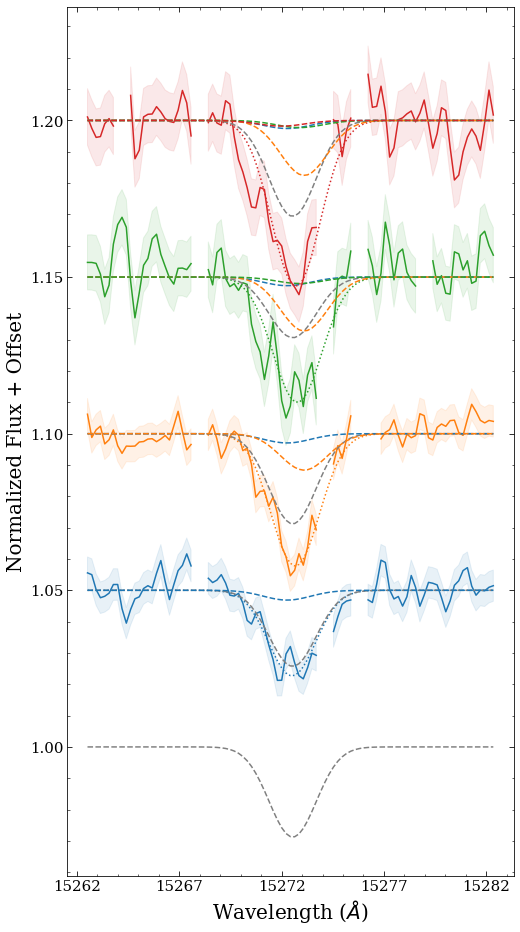

N 1
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [1 4 3 0 2]
signal_recreated.shape (5, 95)
1
4
3
0
2


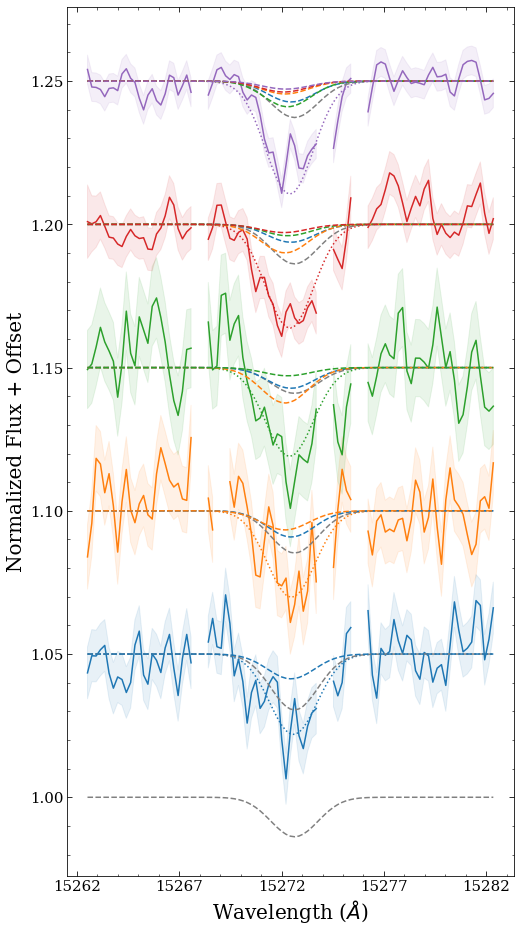

N 2
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [0 1 4 3 2]
signal_recreated.shape (5, 95)
0
1
4
3
2


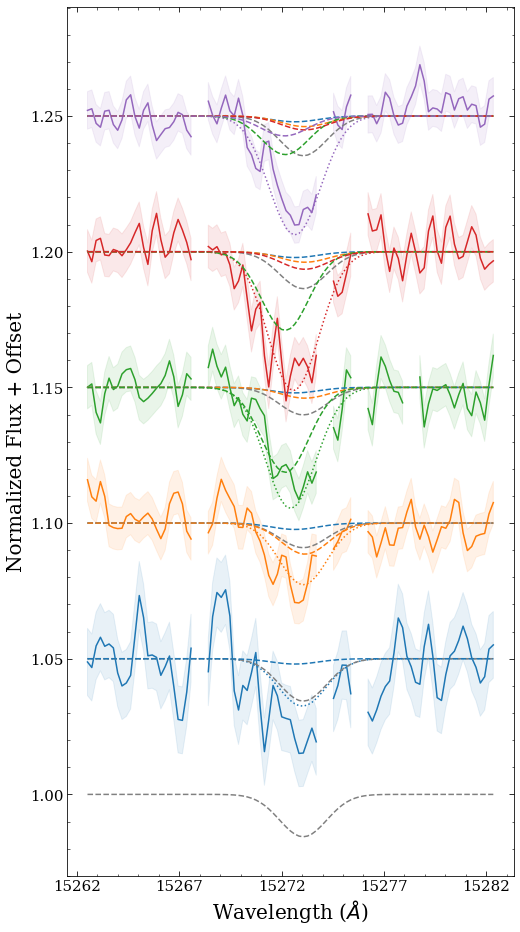

N 3
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [0 2 4 1 3]
signal_recreated.shape (5, 95)
0
2
4
1
3


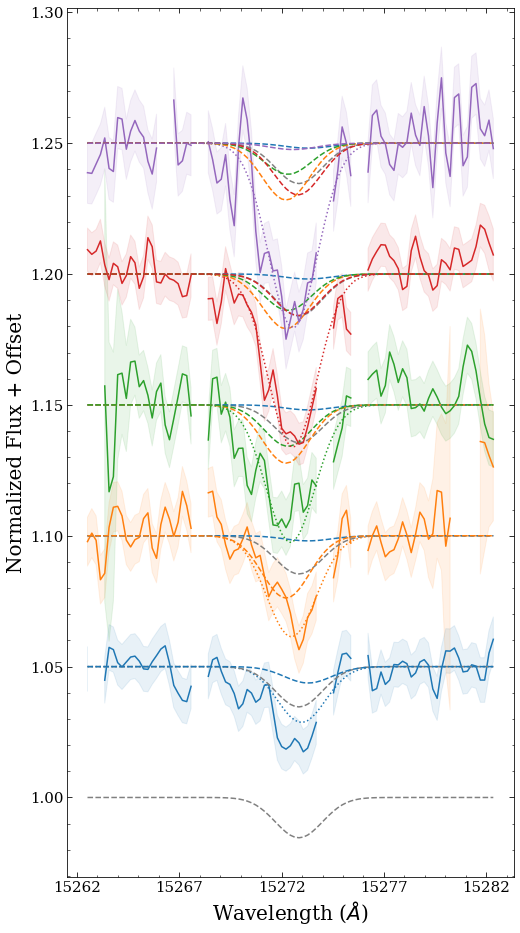

N 4
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [1 2 4 3 0]
signal_recreated.shape (5, 95)
1
2
4
3
0


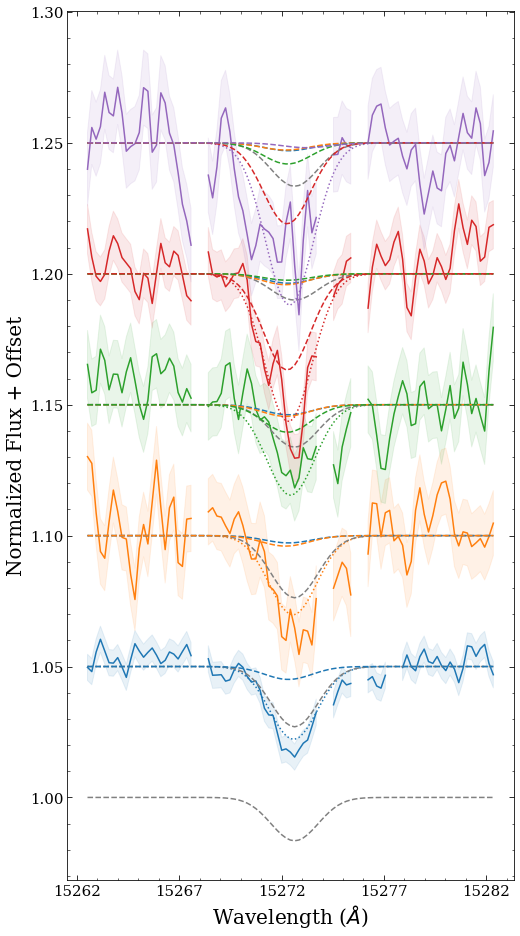

N 5
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [2 4 3 1 0]
signal_recreated.shape (5, 95)
2
4
3
1
0


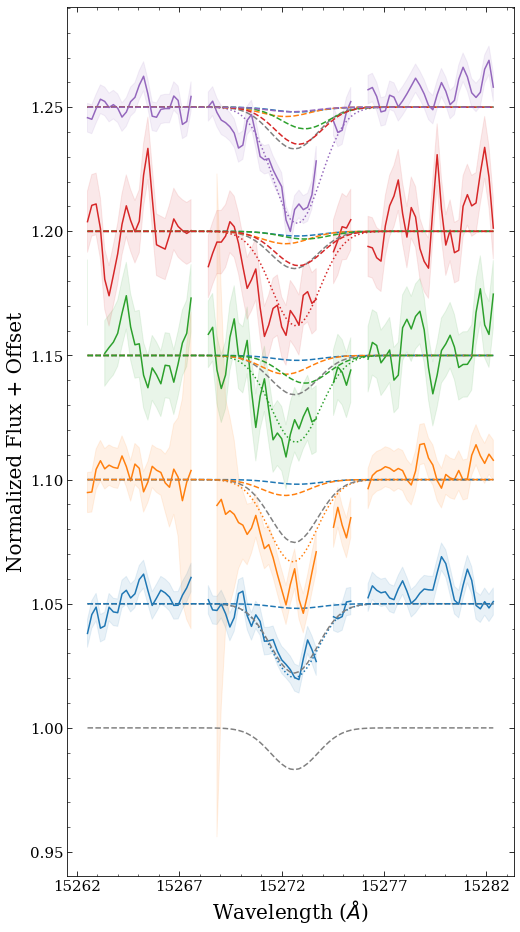

N 6
ndim 5
nstars 4
medians shape (25,)
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [0 3 2 1]
signal_recreated.shape (4, 95)
0
3
2
1


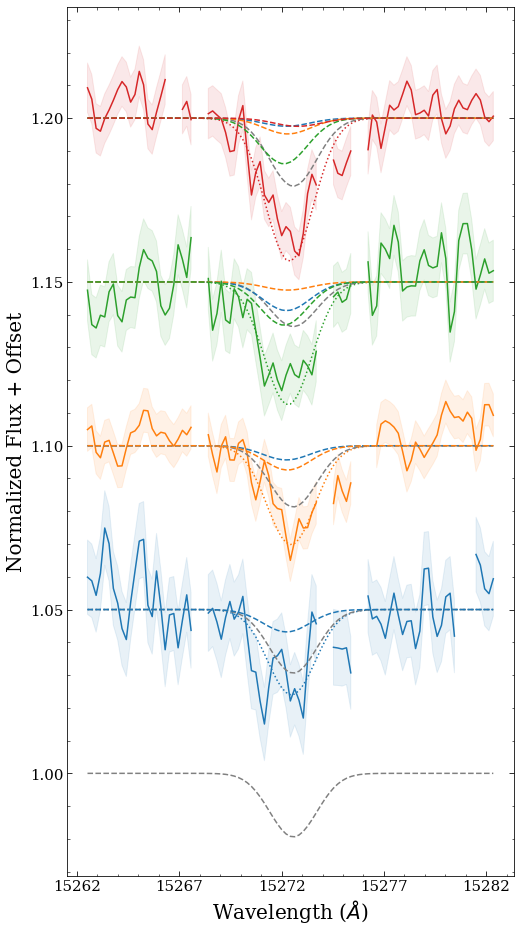

N 7
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [4 1 2 3 0]
signal_recreated.shape (5, 95)
4
1
2
3
0


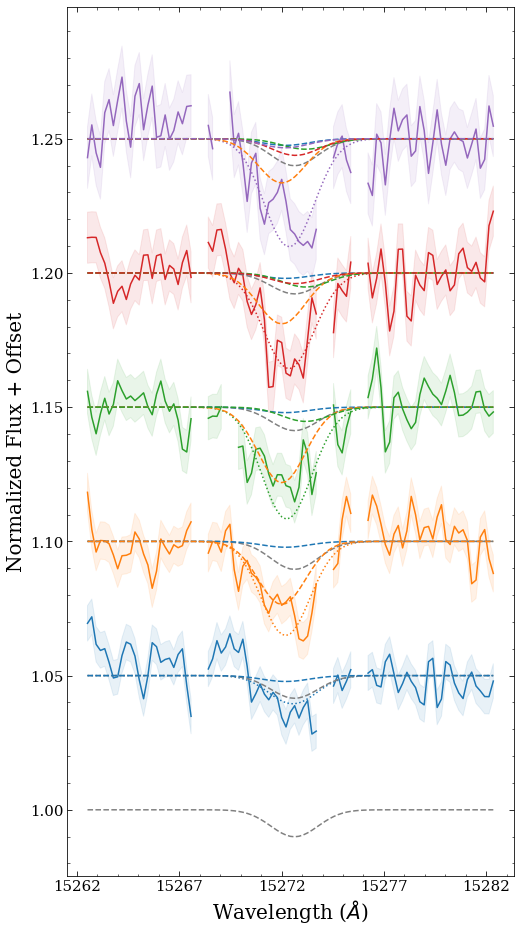

N 8
ndim 5
nstars 5
medians shape (30,)
med_velo shape (5,)
med_dAV_dd shape (5, 5)
order_inds [3 4 1 2 0]
signal_recreated.shape (5, 95)
3
4
1
2
0


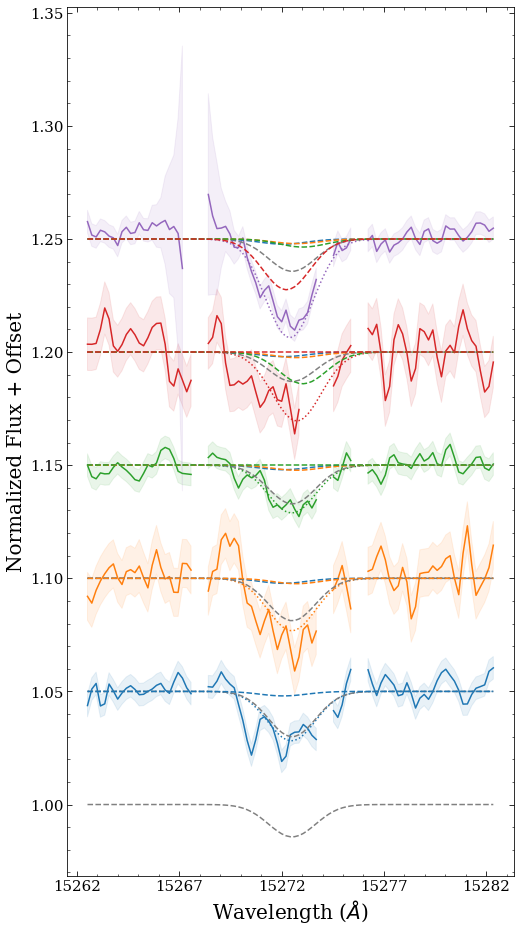

N 9
ndim 5
nstars 4
medians shape (25,)
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [3 0 2 1]
signal_recreated.shape (4, 95)
3
0
2
1


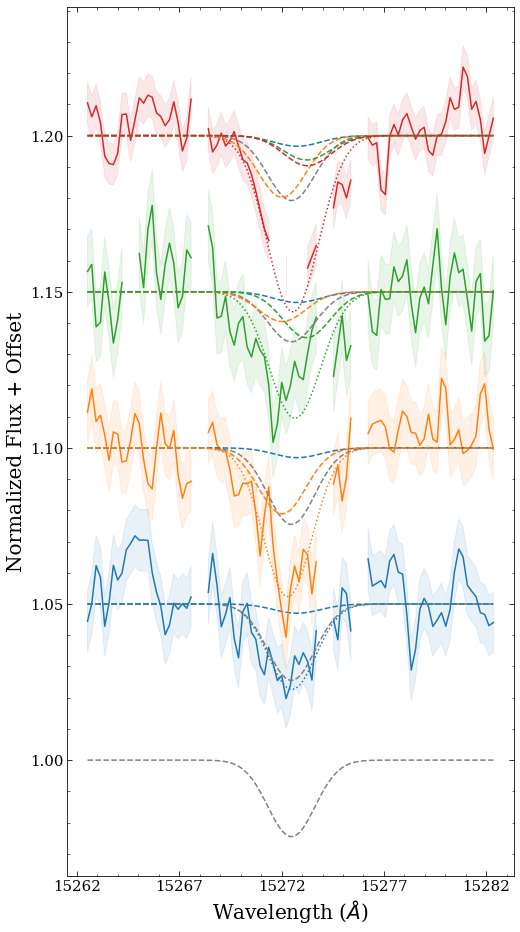

N 10
ndim 7
nstars 6
medians shape (49,)
med_velo shape (7,)
med_dAV_dd shape (6, 7)
order_inds [3 2 4 0 1 5]
signal_recreated.shape (6, 95)
3
2
4
0
1
5


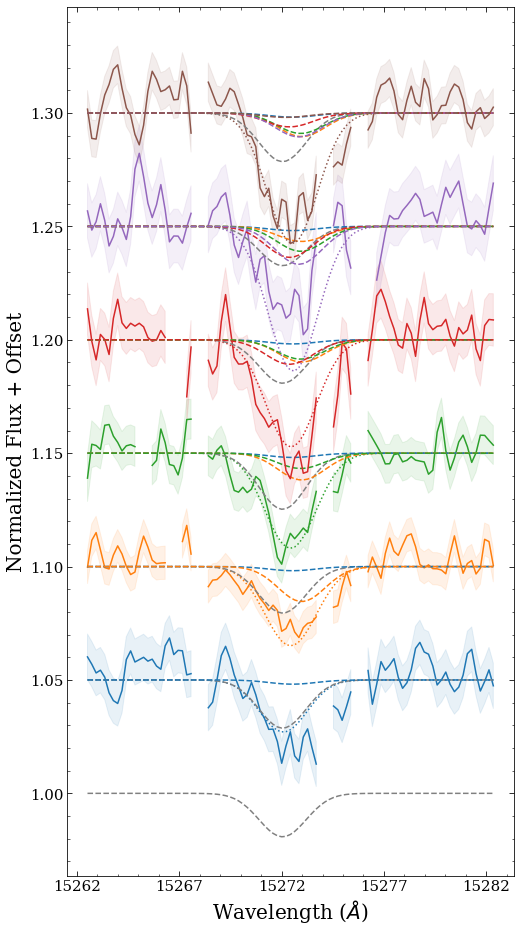

N 11
ndim 5
nstars 4
medians shape (25,)
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [1 3 0 2]
signal_recreated.shape (4, 95)
1
3
0
2


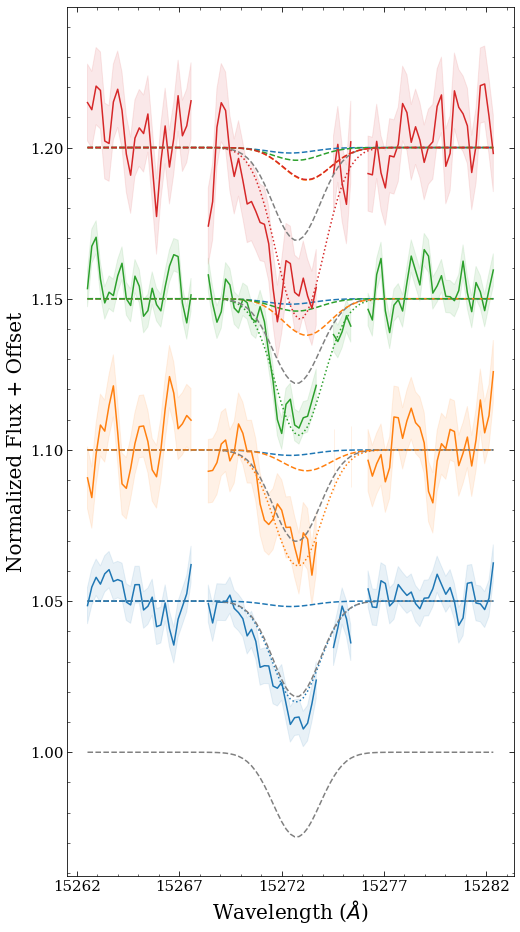

N 12
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [4 1 2 0 3]
signal_recreated.shape (5, 95)
4
1
2
0
3


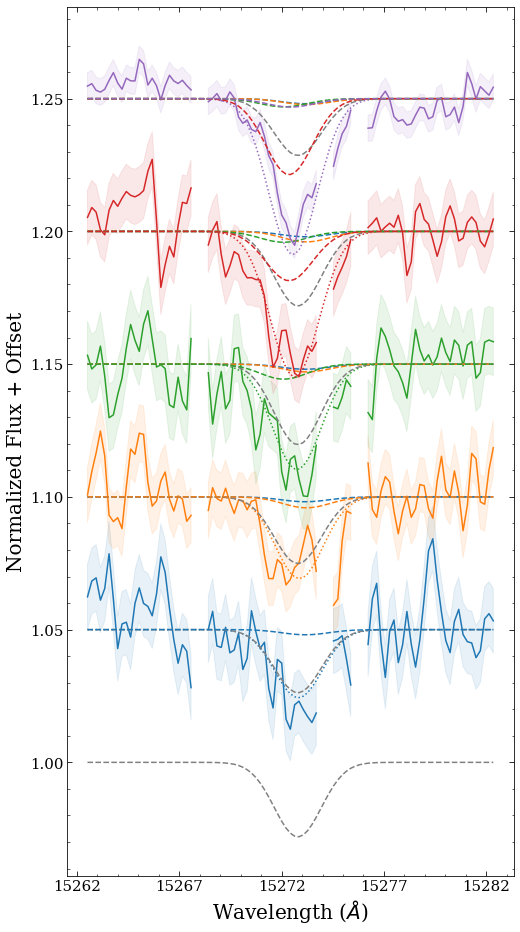

N 13
ndim 5
nstars 4
medians shape (25,)
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [2 3 1 0]
signal_recreated.shape (4, 95)
2
3
1
0


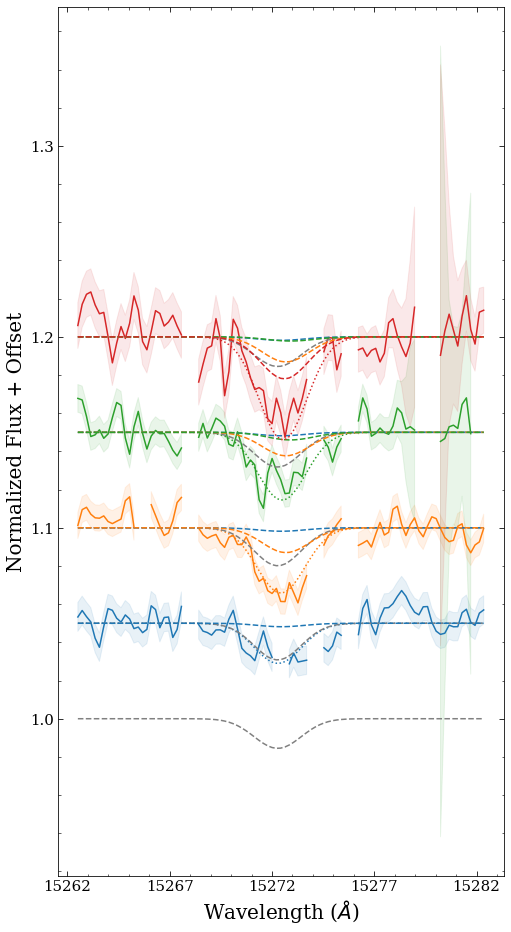

N 14
ndim 6
nstars 5
medians shape (36,)
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [4 1 0 3 2]
signal_recreated.shape (5, 95)
4
1
0
3
2


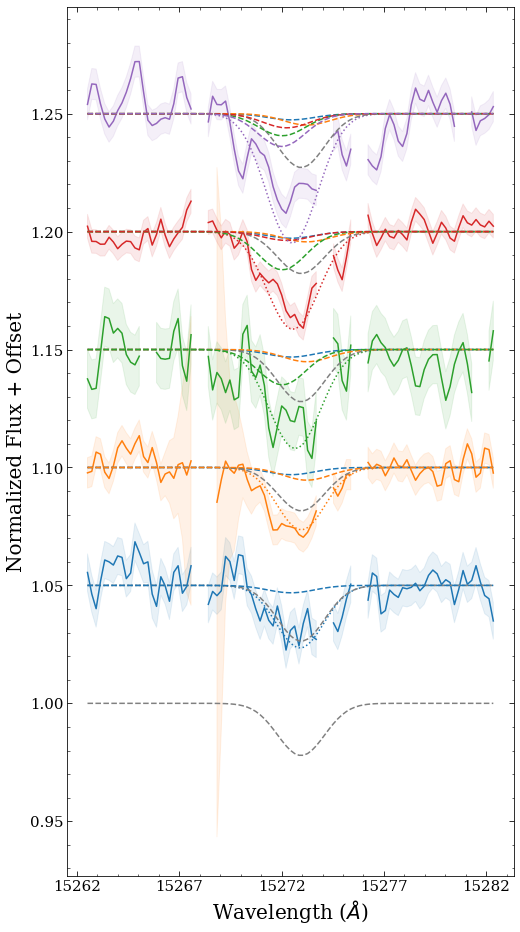

In [39]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

#     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
#         print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB

def plot_DIBS_fg(sampler, sl, plot_objs = None, bestprob = False):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs

    ndim = len(sl.voxel_dAVdd)
    print('ndim', ndim)
    nstars = len(sl.stars)
    print('nstars', nstars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)
    print('medians shape', medians.shape)

    ## NEW THING
    if bestprob:
        lp = sl.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
#     print(med_dAV_dd)
    print('med_velo shape', med_velo.shape)
    print('med_dAV_dd shape', med_dAV_dd.shape)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
    print('order_inds', order_inds)

    signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

    print('signal_recreated.shape', signal_recreated.shape)


    ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'dashed', color ='grey')

    for i in range(len(order_inds)):
        ii = order_inds[i]
        print(ii)
        offset_i = i+1

        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dashed', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux + Offset', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    # ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))

recreated_signals = []

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    # ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_sl{}.png'.format(name_i))

    plt.show()

    ### Added 05.13 ###
    recreated_signals.append(reproducedDIBs)


In [40]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])


In [41]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]

    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / recreated_signals_i, axis = 1)
    print(chi2_per_signal)

[0.00121587 0.00422168 0.00500319 0.00166164]
[0.00366304 0.00639562 0.00268824 0.01157979 0.00869779]
[0.01184573 0.00383125 0.00352321 0.00431001 0.00419144]
[0.00406447 0.00501916 0.00921813 0.00949357 0.01014395]
[0.01730585 0.00170069 0.01056098 0.00821192 0.01110534]
[0.00363917 0.01236161 0.00308611 0.00881288 0.00699792]
[0.00731018 0.00353639 0.00562286 0.00337332]
[0.00818462 0.00546939 0.0055424  0.00648018 0.00530947]
[0.00225334 0.00129023 0.00777642 0.00307143 0.00641549]
[0.00675795 0.00452357 0.00978603 0.00741324]
[0.00844959 0.01636562 0.00387597 0.00737272 0.00368241 0.00805481]
[0.0042966  0.00288897 0.01085477 0.00716713]
[0.00688044 0.00935324 0.0083032  0.00451134 0.01164767]
[0.00995026 0.0051711  0.00378239 0.00346045]
[0.00852411 0.00228489 0.00990889 0.00233137 0.00448072]


[0.68565329 0.88526457 0.81158458 0.76559481 0.88882912 1.00907042
 0.78508374 1.06795009 0.80334291 0.96411756 0.97443187 1.07038313
 1.06686678 0.8878011  1.20103138]


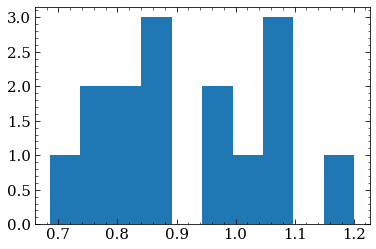

In [42]:
fig, ax = plt.subplots()
ax.hist(chi2s)
print(chi2s)

In [95]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])
            
        plot_guides = True
        if plot_guides:
            for pos in bin_pos:
                ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
                axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])


    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


N  0
[375.00500488 409.25457764 472.06390381 547.76434326 577.60766602]
[ 4.83486838 11.72912485  0.04139602  4.9557916  -2.78674744]
[409.25457764 472.06390381 547.76434326 577.60766602]
(array([-0.05070188, 27.38309884]), array([[ 2.26115174e-03, -1.12092518e+00],
       [-1.12092518e+00,  5.63069094e+02]]))


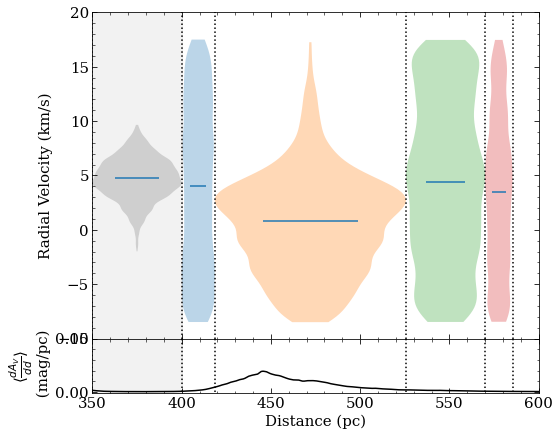

N  1
[375.00500488 419.78927612 455.03808594 475.51266479 485.52267456
 507.90985107]
[ 6.35719653 -5.98911141 -4.79288367 -6.30000555 -5.55015346 -2.22703839]
[419.78927612 455.03808594 475.51266479 485.52267456 507.90985107]
(array([  0.0324719 , -20.15987807]), array([[ 4.81264499e-04, -2.26460957e-01],
       [-2.26460957e-01,  1.07005911e+02]]))


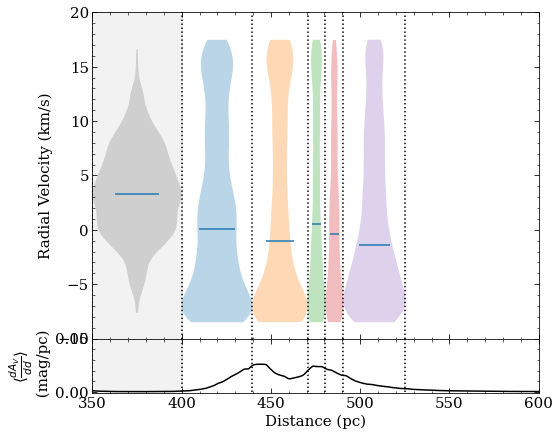

N  2
[375.00500488 405.01501465 415.02502441 450.17236328 495.33456421
 543.1262207 ]
[ 5.94945279 12.74517297  1.20585167  5.8159115  -7.31759239  4.59866572]
[405.01501465 415.02502441 450.17236328 495.33456421 543.1262207 ]
(array([-0.04395037, 23.94779328]), array([[ 4.02637091e-03, -1.84709265e+00],
       [-1.84709265e+00,  8.57330368e+02]]))


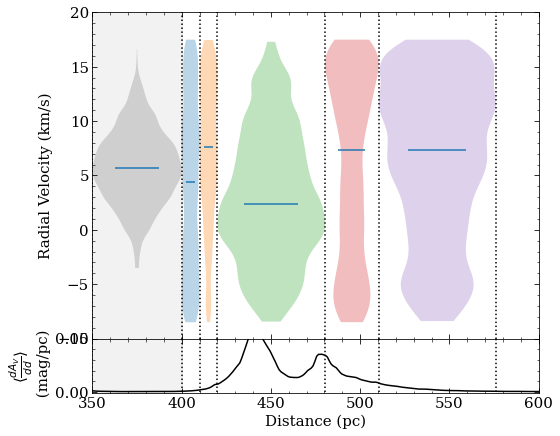

N  3
[375.00500488 405.01501465 430.47247314 468.37747192 511.1282959
 589.63739014]
[ 4.54488976 -2.47999024  5.06968887 -8.21079123  7.43420923 -4.70898824]
[405.01501465 430.47247314 468.37747192 511.1282959  589.63739014]
(array([-0.01274174,  5.76077433]), array([[ 2.31306133e-03, -1.11729236e+00],
       [-1.11729236e+00,  5.50421797e+02]]))


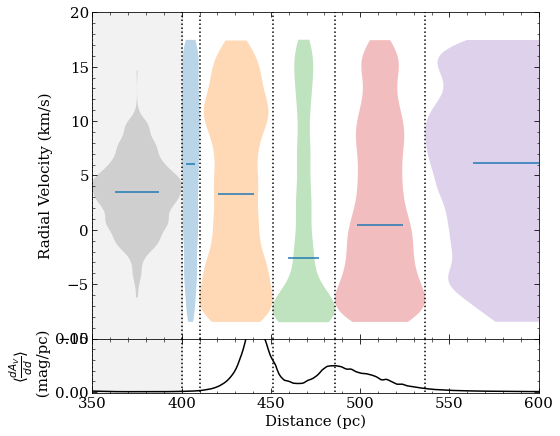

N  4
[375.00500488 410.73428345 426.46356201 437.93457031 496.68527222
 561.67285156]
[ 0.85126961 -1.81922478  6.01233691 14.65934465 -6.46092462 16.40510429]
[410.73428345 426.46356201 437.93457031 496.68527222 561.67285156]
(array([  0.02877674, -11.41949474]), array([[ 1.06976791e-02, -5.06916212e+00],
       [-5.06916212e+00,  2.42958663e+03]]))


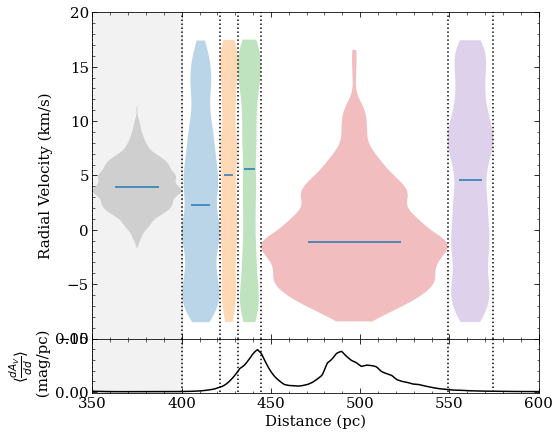

N  5
[375.00500488 405.01501465 424.12689209 444.5123291  478.56817627
 546.32177734]
[11.38993423 12.93340331  1.19495462 -3.37987419 -1.53351428 -5.26796246]
[405.01501465 424.12689209 444.5123291  478.56817627 546.32177734]
(array([-0.09366831, 43.83418371]), array([[ 2.40852950e-03, -1.10494931e+00],
       [-1.10494931e+00,  5.13050357e+02]]))


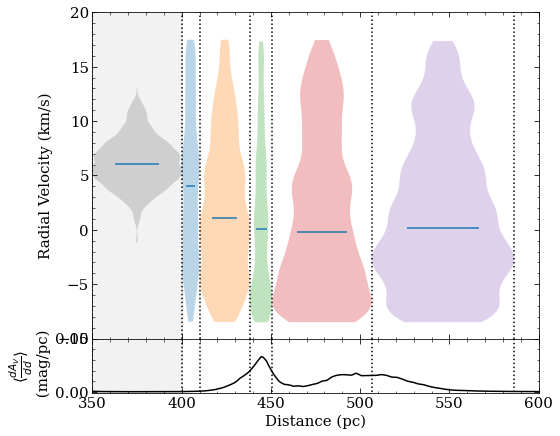

N  6
[375.00500488 441.52374268 488.04251099 519.3347168  557.64611816]
[ 2.07612204 16.34987564  6.07052841 -8.3869396  -4.60522455]
[441.52374268 488.04251099 519.3347168  557.64611816]
(array([ -0.20229262, 103.33406446]), array([[ 6.42348662e-03, -3.25027117e+00],
       [-3.25027117e+00,  1.65534429e+03]]))


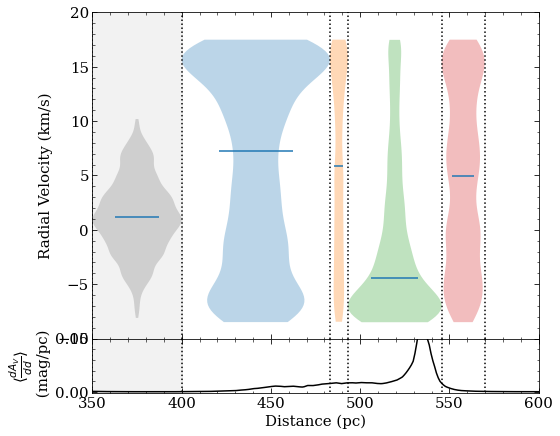

N  7
[375.00500488 406.07263184 453.89193726 500.65362549 515.43652344
 558.07305908]
[ 9.86567292  8.85526835 -7.43122747  6.38924691 -0.16050592  3.75871739]
[406.07263184 453.89193726 500.65362549 515.43652344 558.07305908]
(array([ 0.0171011 , -8.14440213]), array([[ 5.54185426e-03, -2.66550839e+00],
       [-2.66550839e+00,  1.29544332e+03]]))


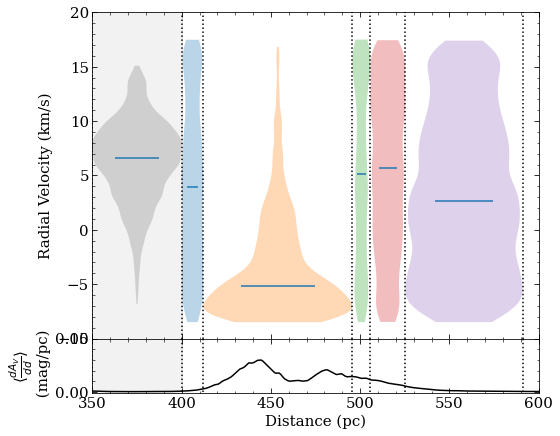

N  8
[375.00500488 407.26959229 419.53417969 451.1105957  518.91821289]
[ 1.25884183  5.96837139 -6.46929319 -5.1931453   3.05140077]
[407.26959229 419.53417969 451.1105957  518.91821289]
(array([  0.0225902 , -10.46439247]), array([[ 6.18266345e-03, -2.80406003e+00],
       [-2.80406003e+00,  1.28479689e+03]]))


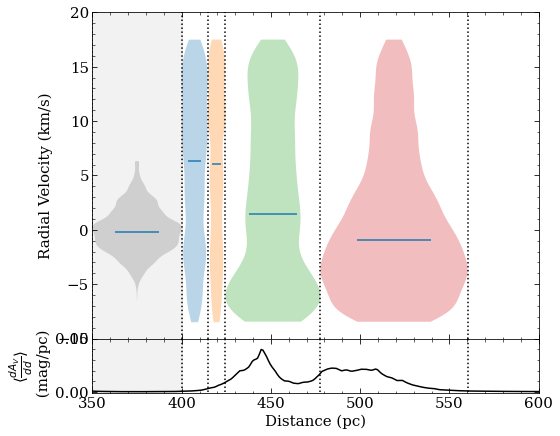

N  9
[375.00500488 413.0881958  456.00408936 500.40039062 559.28851318]
[ 3.57149388 -6.14531653 -1.9891916  -5.80305044 14.31016768]
[413.0881958  456.00408936 500.40039062 559.28851318]
(array([  0.12662817, -60.23161699]), array([[ 3.06128643e-03, -1.45263213e+00],
       [-1.45263213e+00,  6.97566907e+02]]))


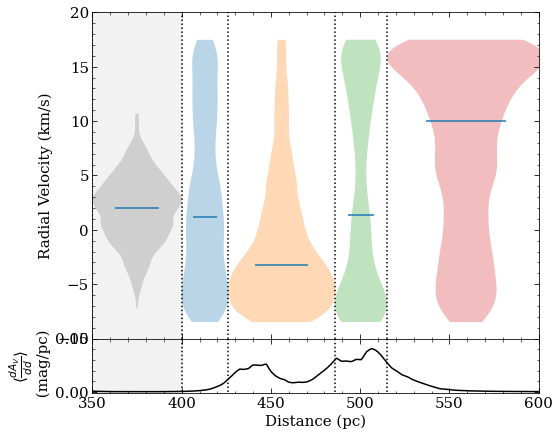

N  10
[375.00500488 405.01501465 427.39996338 457.88537598 486.15039062
 515.6151123  534.92529297]
[-2.76538811 12.4383499  10.67627751 17.39554198 10.32804735 -0.86399546
 -2.92308403]
[405.01501465 427.39996338 457.88537598 486.15039062 515.6151123
 534.92529297]
(array([-0.13321318, 70.39945999]), array([[ 2.00982665e-03, -9.62451160e-01],
       [-9.62451160e-01,  4.65556825e+02]]))


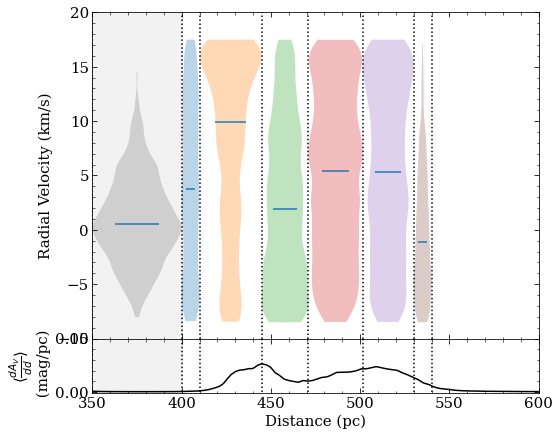

N  11
[375.00500488 405.01501465 430.65368652 456.29232788 481.21447754]
[ 4.82643381 -3.15009442  8.84558001  2.84560871 -2.57964667]
[405.01501465 430.65368652 456.29232788 481.21447754]
(array([-0.01944045, 10.73213683]), array([[ 1.72437819e-02, -7.60621299e+00],
       [-7.60621299e+00,  3.36793219e+03]]))


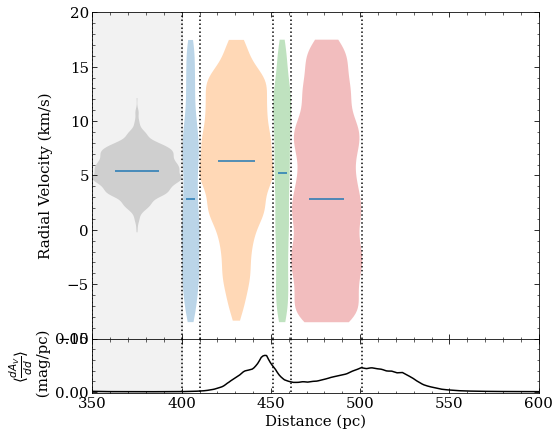

N  12
[375.00500488 406.31265259 417.62030029 429.65344238 474.24975586
 516.82293701]
[ 6.26015901 -2.01185831  7.03932436 -6.78400955 -3.14475638 15.28734674]
[406.31265259 417.62030029 429.65344238 474.24975586 516.82293701]
(array([  0.10339385, -45.12464849]), array([[ 9.70140425e-03, -4.32068465e+00],
       [-4.32068465e+00,  1.93849857e+03]]))


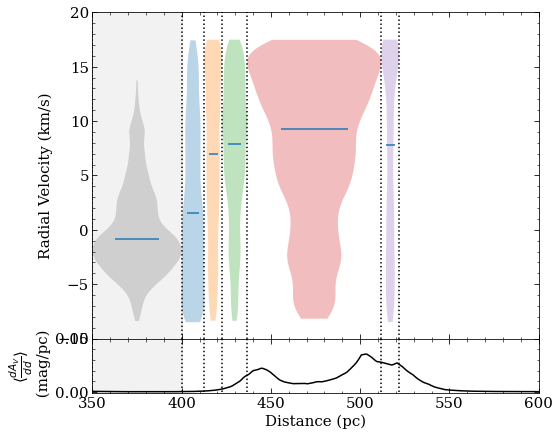

N  13
[375.00500488 405.01501465 432.21722412 459.71051025 490.29187012]
[ 1.69131701 13.51303083 -2.61381461 16.97295267 -1.4066309 ]
[405.01501465 432.21722412 459.71051025 490.29187012]
(array([-0.09283048, 47.81102123]), array([[ 3.32543508e-02, -1.48814875e+01],
       [-1.48814875e+01,  6.69311918e+03]]))


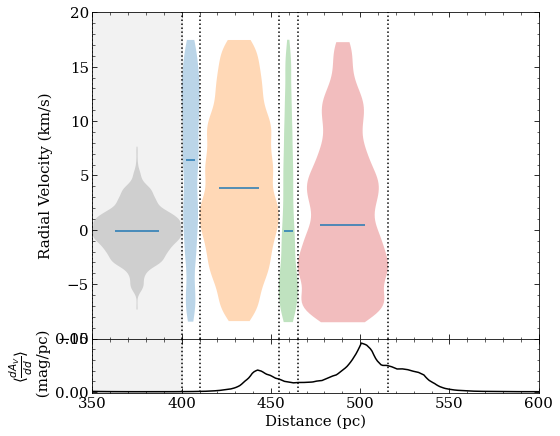

N  14
[375.00500488 417.68438721 443.95129395 473.13568115 501.97814941
 716.83312988]
[ 1.88521176 -3.39496814 16.9755924  -8.00122246 15.69894411 -8.35889472]
[417.68438721 443.95129395 473.13568115 501.97814941 716.83312988]
(array([-0.03948328, 22.24423219]), array([[ 2.62597769e-03, -1.34679393e+00],
       [-1.34679393e+00,  7.24744752e+02]]))


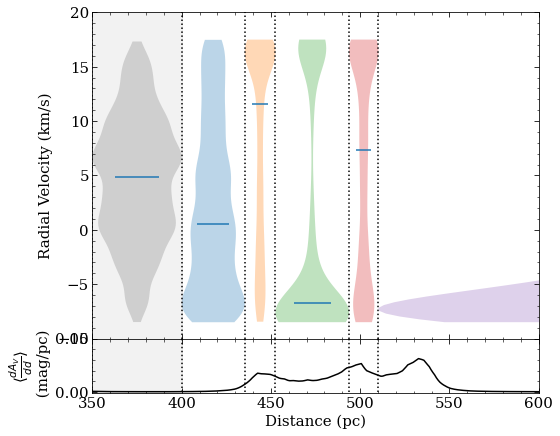

In [97]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])

priorx = np.linspace(-20, 20, 100)

# for i in range(len(sightlines)): 
for i in range(0, len(sightlines)): 

    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})

    

    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, 
                                                        plot_box = False, plot_violin=True, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)



    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] > 400) & (dist_xx[dist_sort] <= 800)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ### ADDDED 03.28 ###
    # fgprior = prior_for_plot(sl_i.l, sl_i.b, priorx)
    # axs[0].plot(5e2 * fgprior + 350, priorx, color = 'grey', linestyle = 'dashed')

    # ### ADDED 03.31 ###
    # profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    # axs[0].plot(600- 5e1*profile, rvel)

    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(350, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    ylim0 = (-10, 20)
    axs[0].set_ylim(*ylim0)
    axs[0].fill_between((350, 400), (ylim0[1], ylim0[1]), (ylim0[0], ylim0[0]), color = 'grey', alpha = 0.1)

    ylim1 = (-0.001, 0.05)
    axs[1].set_ylim(*ylim1)
    axs[1].fill_between((350, 400), (ylim1[1], ylim1[1]), (ylim1[0], ylim1[0]), color = 'grey', alpha = 0.1)

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    # name_i = 'veldist_' + str(i)
    fig.savefig('RUNS_H5/figures_0602a/0602a_VelModels/velo_plot_{}.png'.format(i) )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

In [45]:
matplotlib.__version__


'3.9.0'

0


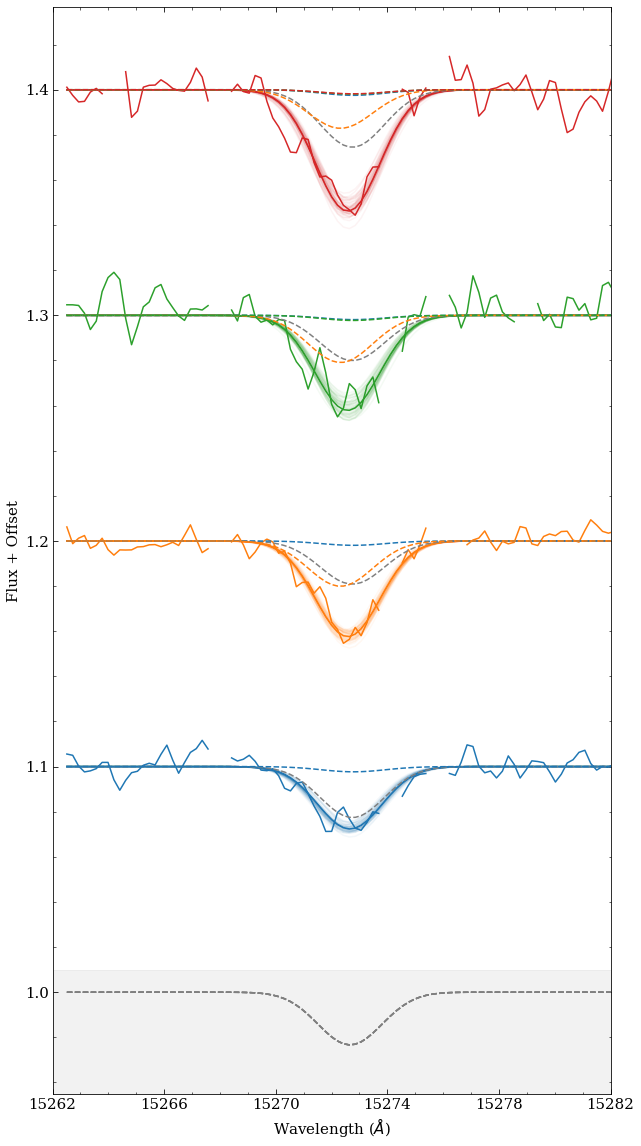

1


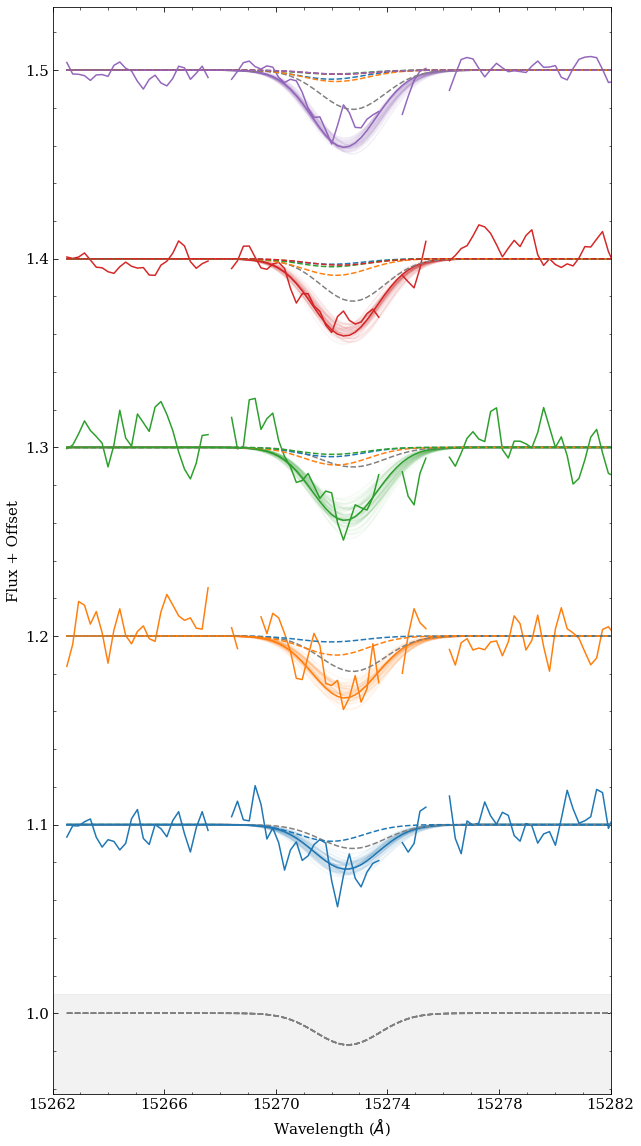

2


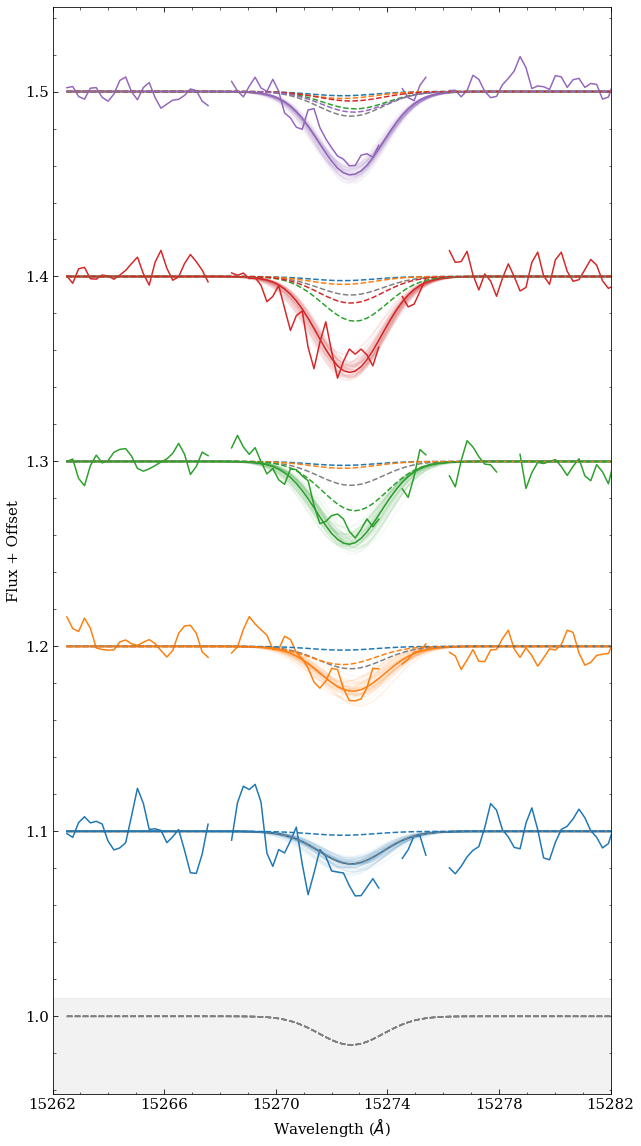

3


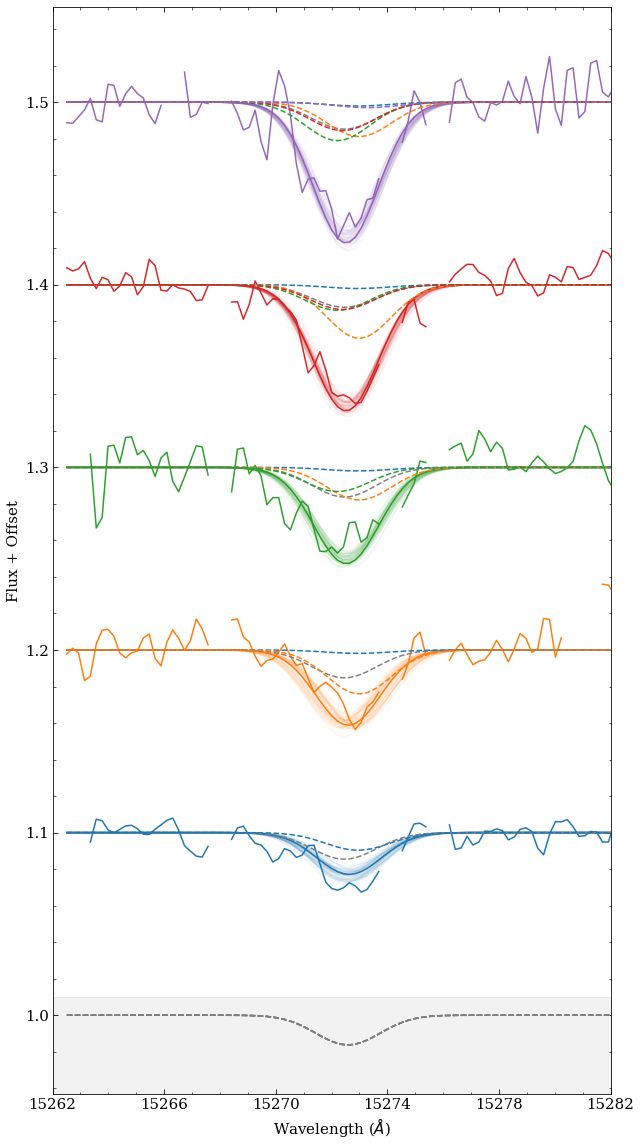

4


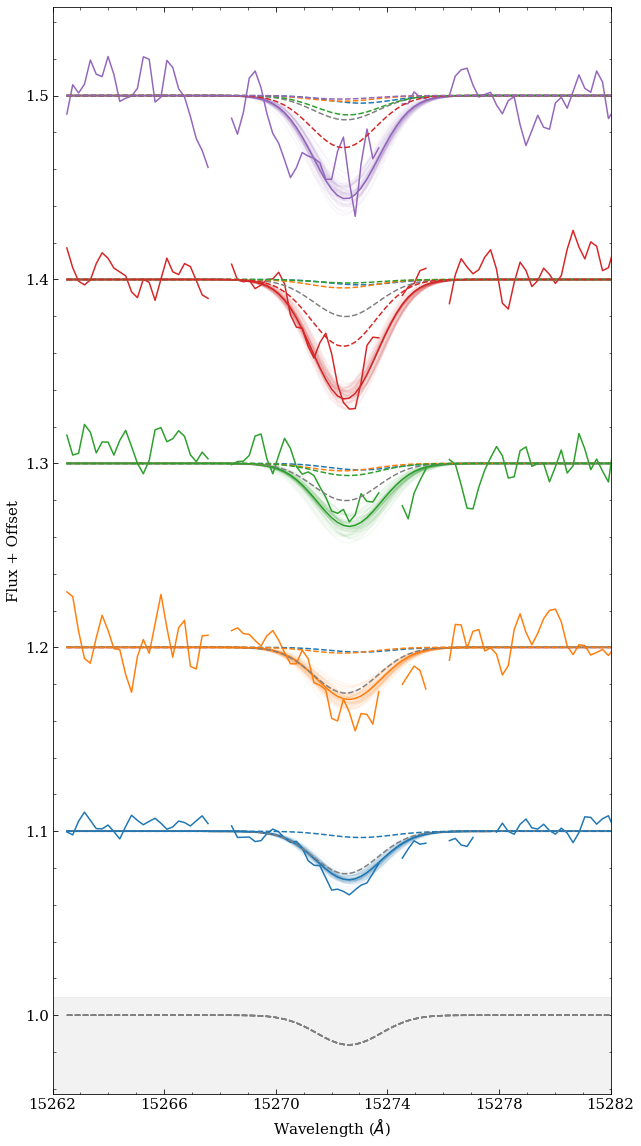

5


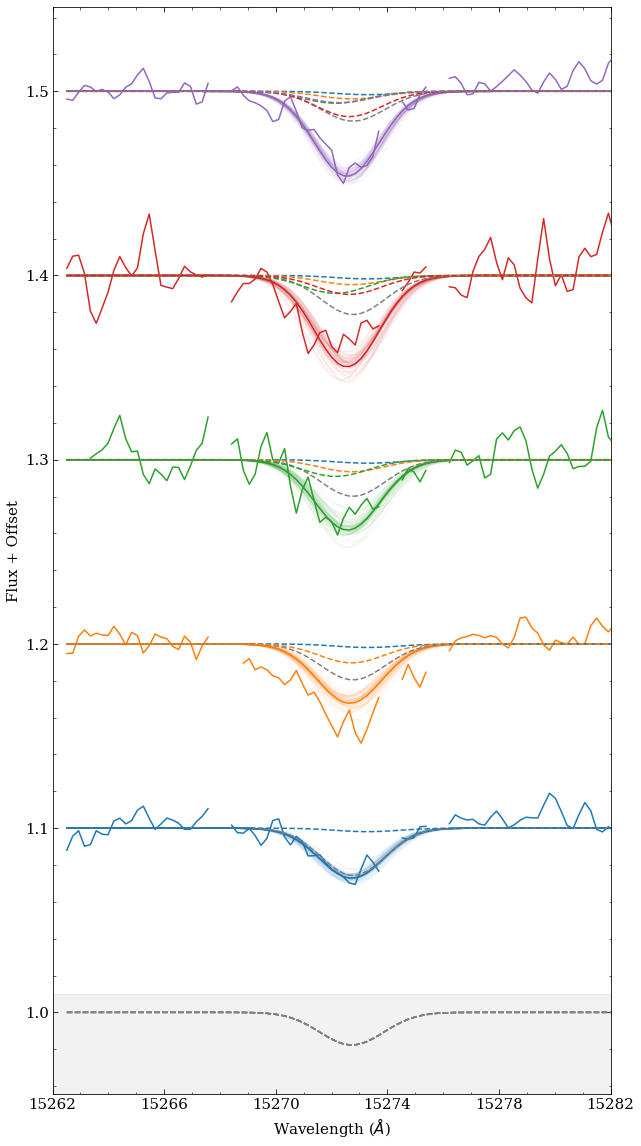

6


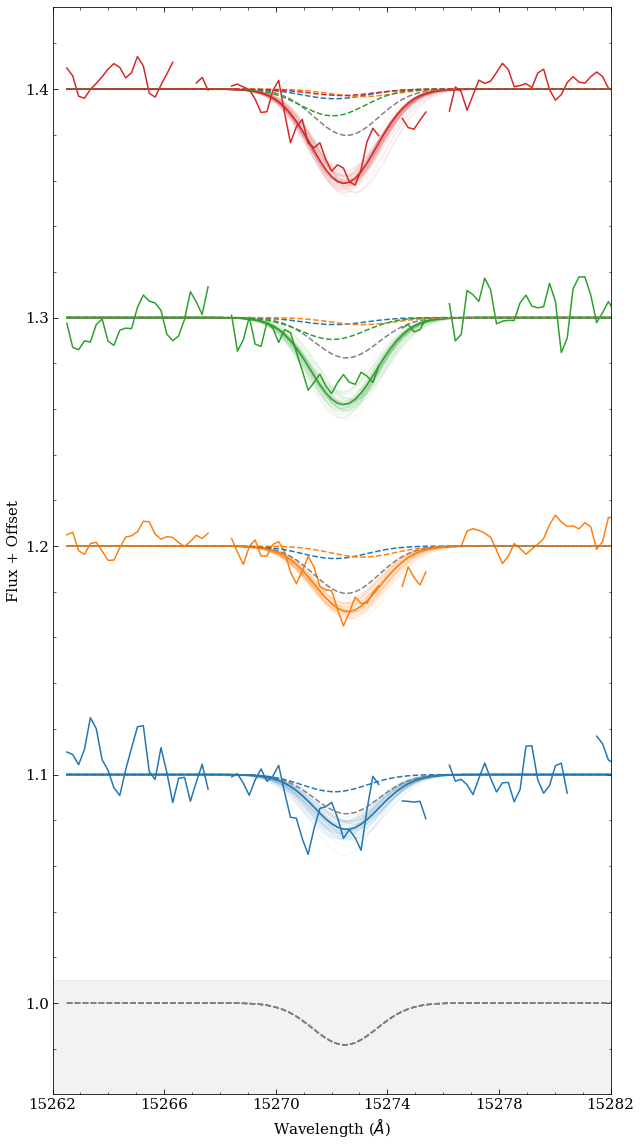

7


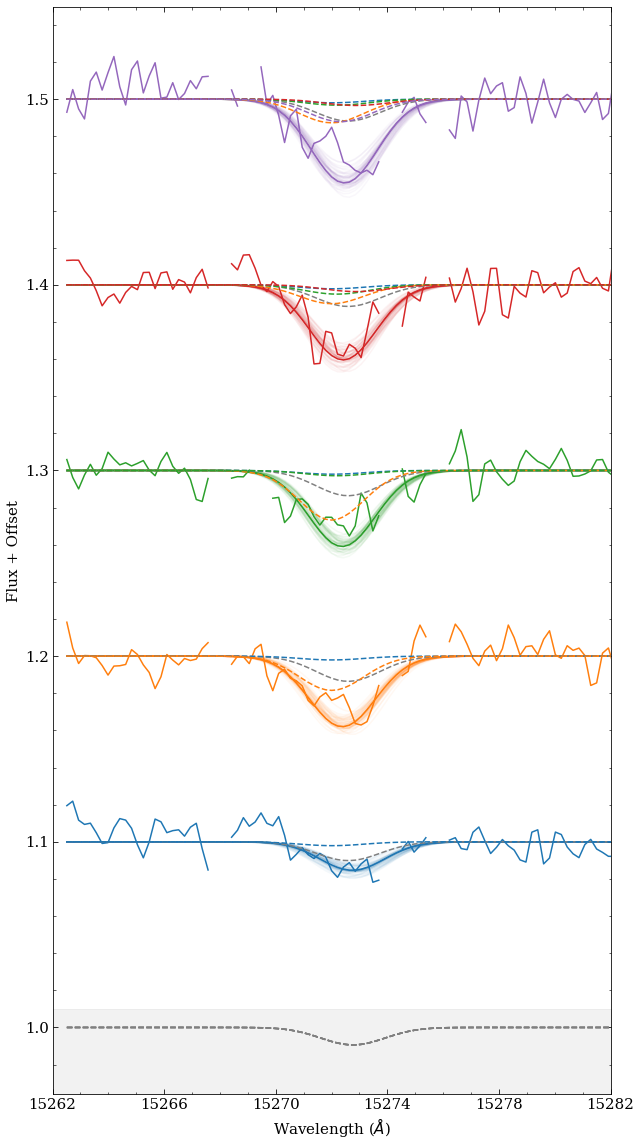

8


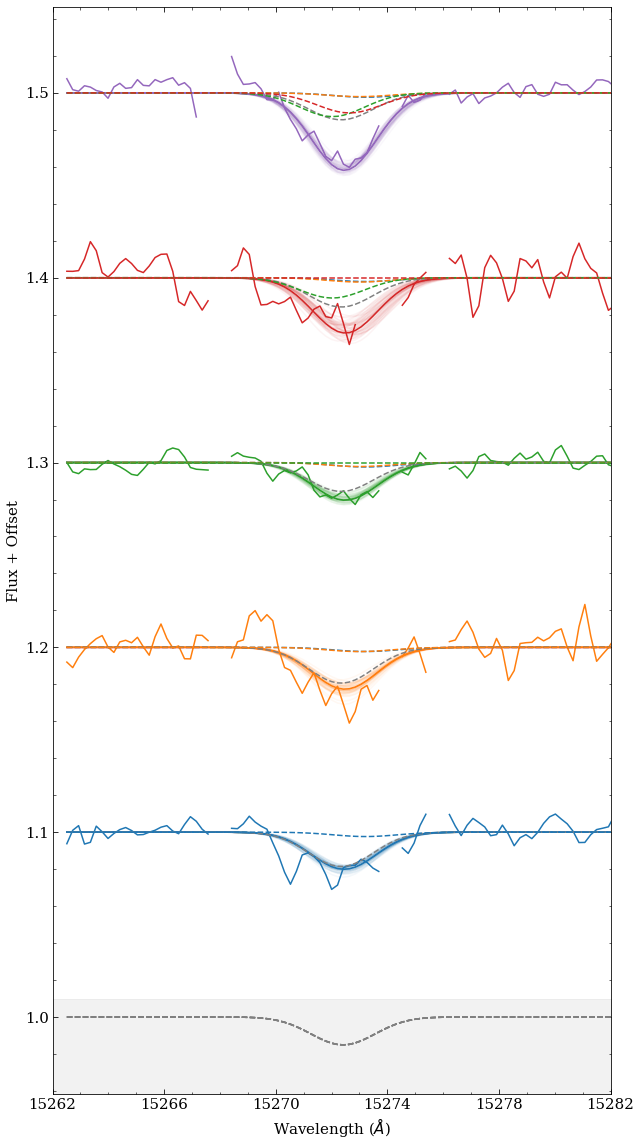

9


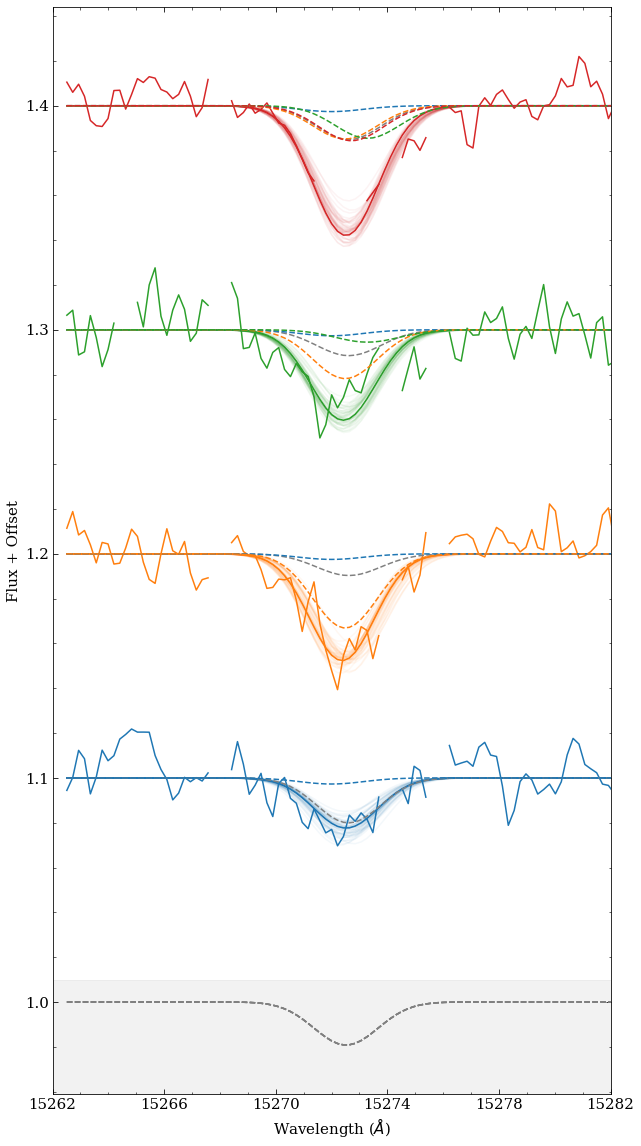

10


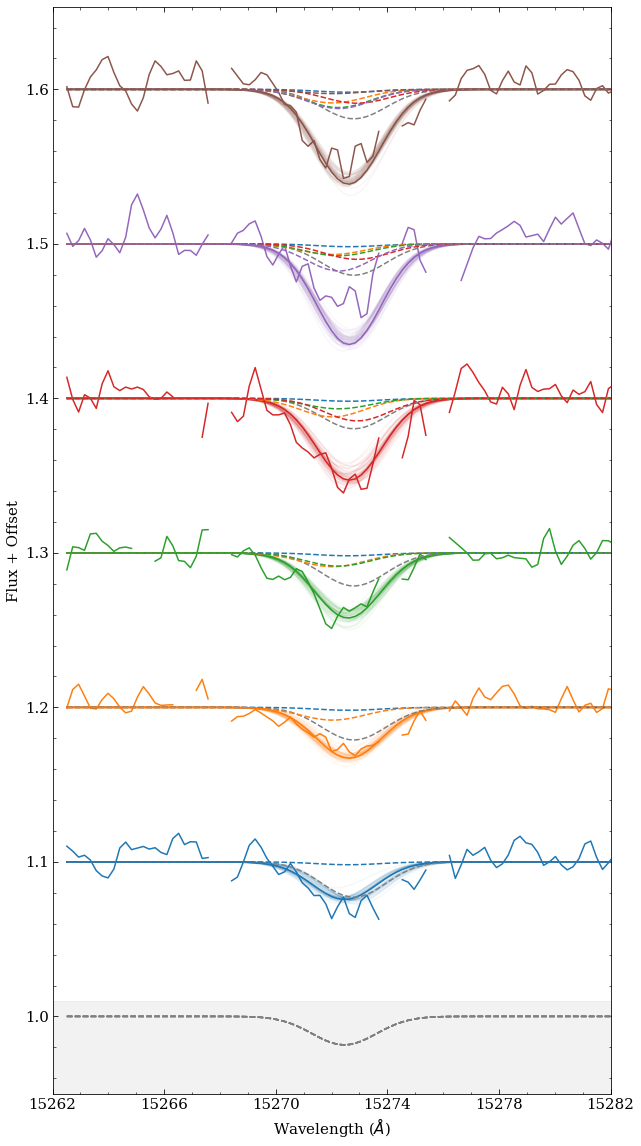

11


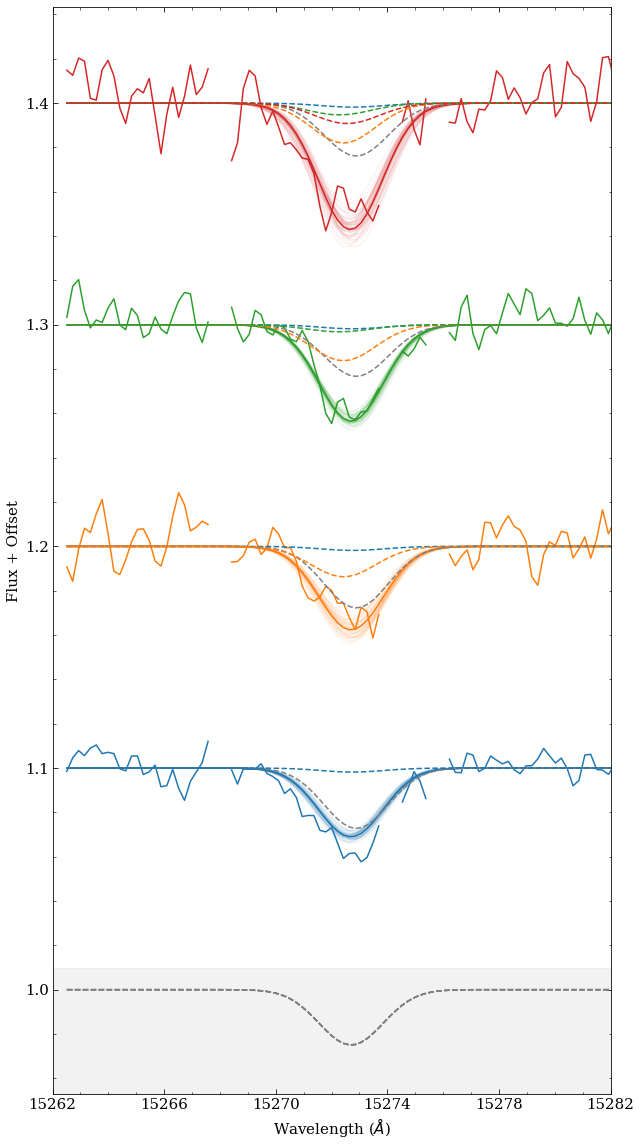

12


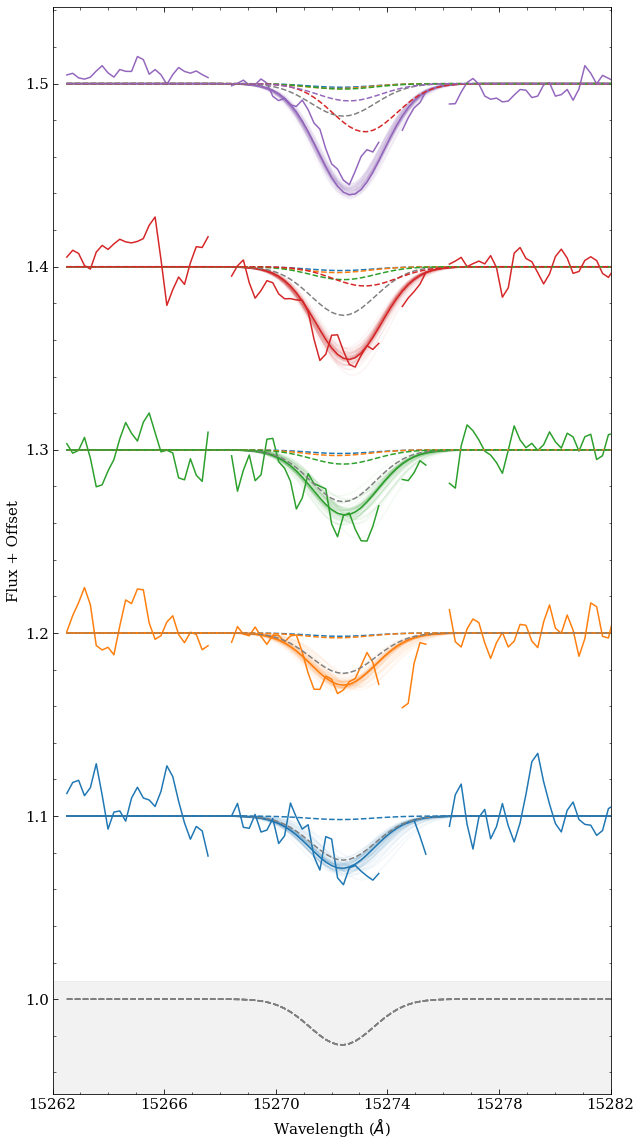

13


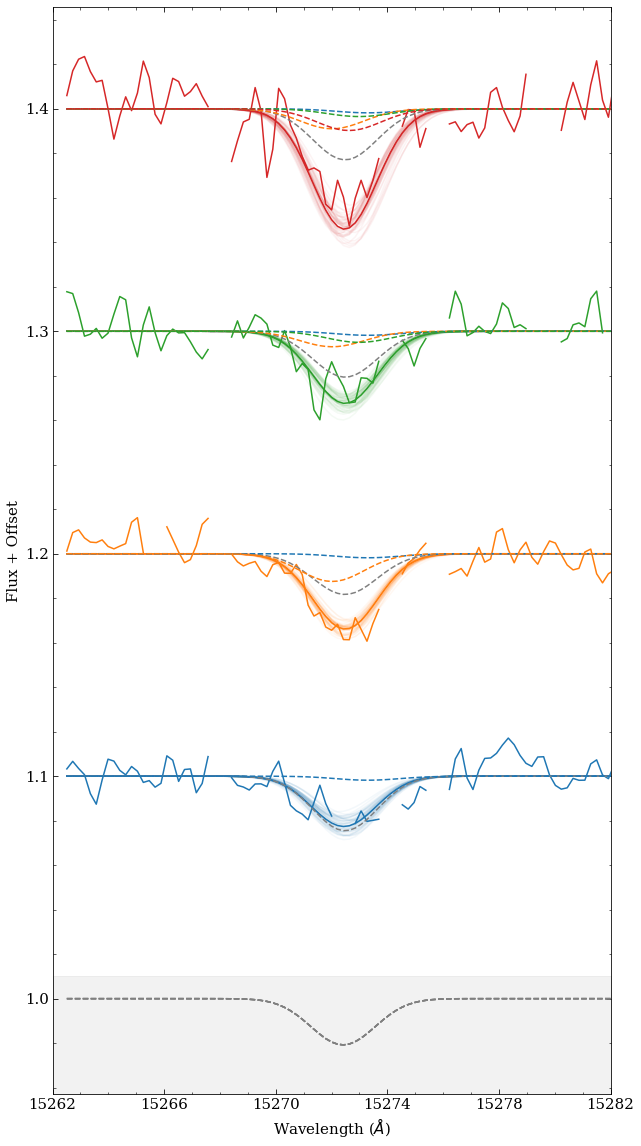

14


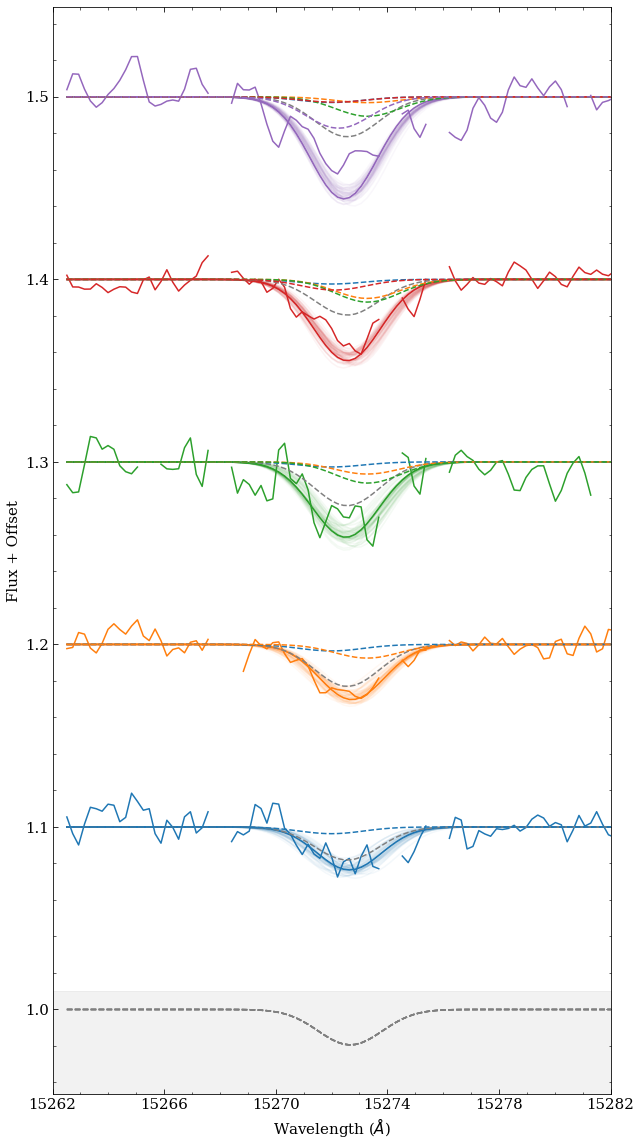

In [64]:
def make_plots_sample(samples, sl, logprob = None, chain = None):
    v = np.nanmedian(samples[:, :sl.ndim], axis = 0)
    davdd = np.nanmedian(samples[:, sl.ndim:], axis = 0).reshape(-1, sl.ndim)
    # av_offset = np.nanmedian(samples[:, 2*sl.ndim:], axis = 0)
    # davdd_all = np.ones((sl.nsig, sl.ndim)) * davdd + av_offset.reshape((sl.nsig, sl.ndim))

    if False: 
        best_step, best_walker = np.unravel_index(np.argmax(logprob), logprob.shape)
        davdd = chain[best_step, best_walker, sl.ndim:2*sl.ndim]
#         print(davdd.shape)
        davdd_all = davdd * np.ones((sl.nsig, sl.ndim)) + av_offset.reshape((sl.nsig, sl.ndim))

    def sample_signal():
        idx = (np.random.choice(samples.shape[0]))
        v = samples[idx, :sl.ndim]
        av = samples[idx, sl.ndim:].reshape(-1, sl.ndim)
        # av_scatter = samples[idx, 2*sl.ndim:]
        # davdd_all = av * np.ones((sl.nsig, sl.ndim)) + av_scatter.reshape((sl.nsig, sl.ndim))
        voxeldiffDIB, unsummed_signals, fgdiffDIB  = model_signals_fg(v, sl, av)
        return voxeldiffDIB, unsummed_signals, fgdiffDIB

    model_signals, signal_recreated_unsummed, fg_unsummed = model_signals_fg(v, sl, davdd)
#     print( model_signals.shape)

    fig, ax = plt.subplots(figsize = (10, 20))

    samp_signal = np.zeros((50, len(sl.stars), len(wavs_window)))
    samp_unsummed = np.zeros((50, len(sl.stars), len(sl.bins)-1, len(wavs_window)))
    samp_fgdiffDIB = np.zeros((50, len(sl.stars), len(wavs_window)))

    for idx in range(50):
        voxeldiffDIB, unsummed_signals, fgdiffDIB = sample_signal()
        samp_signal[idx, :, :] = voxeldiffDIB
        samp_unsummed[idx, :, :] = unsummed_signals
        samp_fgdiffDIB[idx, : :] = fgdiffDIB

    order_inds = np.array(np.argsort(sl.stars['DIST']))

    sep = 0.1
    offset = 0.1

    # signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # bindex = sl.bin_inds[ii]
        # ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        # ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
        #                  sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)


        ax.plot(wavs[window], model_signals[ii, :] + sep * i + offset, color = 'C{}'.format(i))        
        ax.plot(wavs[window], sl.signals[ii, :]+ sep * i + offset, color = 'C{}'.format(i))
        for k in range(50):
            # samp, _, _ = sample_signal()
            ax.plot(wavs[window], samp_signal[k, ii, :] + sep * i + offset, color = 'C{}'.format(i), alpha = 0.05)
        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, unsummed_signals[ii, j, : ] + 1  + sep * i + offset, color=col, linestyle = 'dashed', alpha = 1)
        


        ax.set_xlabel('Wavelength ($\AA$)')
        ax.set_ylabel('Flux + Offset')
        ax.plot(wavs[window], fg_unsummed[0, :]  -sep + offset, linestyle = 'dashed', color ='grey',)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(15272-10, 15272 + 10)
    ax.fill_between([15272-10, 15272+10], [1 + 0.1 * sep, 1 + 0.1 * sep], [ymin, ymin], color = 'grey', alpha = 0.1)
        
    ax.set_xticks(np.arange(15272-10, 15272+14, 4))
    return fig, ax        



for i in range(len(sightlines)):
    print(i)
    samples = sightlines[i].sampler.chain.swapaxes(0,1)[-100:, :, :].reshape(-1, sightlines[i].sampler.chain.shape[-1])

    fig, ax = make_plots_sample(samples, sightlines[i])
    fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_realizations_sl{}.png'.format(name_i))

    plt.show()

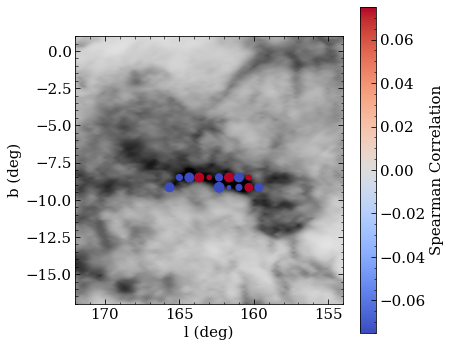

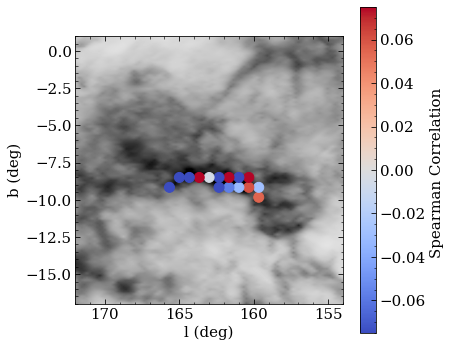

In [106]:
from scipy.stats import spearmanr
start = 0
stop = None
def gradientmetric_deriv(array, dist):    
    a, b = np.meshgrid(array, array)
    c, d = np.meshgrid(dist, dist)
    grad_matrix = np.triu(b - a)
    deltadist = np.triu(d - c)
    nz = grad_matrix != 0
    grad_matrix[nz] = grad_matrix[nz] / deltadist[nz]
    shape = grad_matrix.shape[0]
    return np.sum(grad_matrix) / (0.5 * shape * (shape - 1))

sl_metrics = np.zeros(len(sightlines))
sl_spearman = np.zeros((len(sightlines), 2))

sl_spearman_samples = np.zeros((len(sightlines), 2))


v_all = np.array([], dtype = float)
verr_all = np.array([], dtype = float)
d_all = np.array([], dtype = float)
l_sightline = np.array([], dtype = float)
sl_counts = np.zeros(len(sightlines))
median_velo_sightline = np.zeros(len(sightlines))


velocity_samples_all = np.array([])
distance_samples_all = np.array([])

for i in range(len(sightlines)):
    sl_i = sightlines[i]
    ndim = len(sl_i.voxel_dAVdd)
    walker_max = sl_i.sampler.chain.shape[1]
    min_walker_val = walker_max - 100
    sampler = sl_i.sampler
    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))
    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]
    bin_dist = sl_i.bins[1:]

    select_cloud = bin_dist > 401

    median_velo_sightline[i] = np.nanmedian(samples[:, :ndim])

    metric = np.sum(gradientmetric_deriv(med_velo[select_cloud], bin_dist[select_cloud]))
    sl_metrics[i] = metric

    spearman_correlation = spearmanr(bin_dist[select_cloud], med_velo[select_cloud])
    sl_spearman[i, 0] = spearman_correlation.correlation
    sl_spearman[i, 1] = spearman_correlation.pvalue

    v_all = np.concatenate([v_all,med_velo])
    verr_all = np.concatenate([verr_all, std_velo]) 
    d_all = np.concatenate([d_all, bin_dist])

    l_sightline = np.concatenate([l_sightline, l_sample[i] * np.ones(len(med_velo))])
    sl_counts[i] = len(med_velo)
    
    velocity_samples = (samples[:, :ndim])
    distance_samples = (np.ones(velocity_samples.shape) * bin_dist)
    select_cloud_samples = distance_samples > 401
    spearman_samples = spearmanr(distance_samples[select_cloud_samples].flatten(), velocity_samples[select_cloud_samples].flatten(),)
    sl_spearman_samples[i, 0] = spearman_samples.correlation
    sl_spearman_samples[i, 1] = spearman_samples.pvalue
    
    distance_samples_all = np.concatenate([distance_samples_all, distance_samples.flatten()])
    velocity_samples_all = np.concatenate([velocity_samples_all, velocity_samples.flatten()])
    
    
    

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:, 0], s= 100 * (1-sl_spearman[:, 1]), vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman_samples[:, 0], s= 100 * (1-sl_spearman_samples[:, 1]), vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation ')
plt.show()

# sl_spearman.astype(np.float16)
# fig, ax = plt.subplots()
# fil = np.nansum(crit_filament)
# fil_idx = np.sum(sl_counts[:fil]).astype(int)

# ax.errorbar(d_all[:], v_all[:], yerr = verr_all[:], fmt = '.', capsize = 4, color = 'grey')

# points = ax.scatter(d_all[:], v_all[:], c = l_sightline[:], zorder = 5, )

# ax.set_xlim(380, 600)
# ax.set_xlabel('Distance (pc)')
# ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')
# plt.show()

In [98]:
print(sl_spearman_samples[:, 0])
print(sl_spearman_samples[:, 1])

[-0.05502367 -0.11426045  0.0409125  -0.02662566 -0.09582837 -0.25495265
 -0.04040512 -0.02751129 -0.0641141   0.16502572 -0.04257634 -0.0496402
  0.31300976 -0.03552192 -0.17788888]
[7.15933689e-167 0.00000000e+000 2.62770698e-111 3.44846216e-048
 0.00000000e+000 0.00000000e+000 7.88013701e-091 2.49975067e-051
 6.09767606e-226 0.00000000e+000 4.02195639e-140 3.72894651e-136
 0.00000000e+000 1.28509425e-070 0.00000000e+000]


In [49]:
sl0 = sightlines[0]
vsamps = sl0.sampler.chain[:, -100:, :sl0.ndim].reshape((-1, sl0.ndim))
bind = sl0.bins[1:]
sampd = bind * np.ones(vsamps.shape)

In [50]:
sampd.flatten()

array([400.01000977, 418.49911499, 525.62872314, ..., 525.62872314,
       569.89996338, 585.31536865])

In [51]:
np.flip(np.argsort((sl_spearman[:, 0])))

array([12,  2,  9,  4, 10,  3, 13, 11,  6, 14,  8,  7,  0,  1,  5])

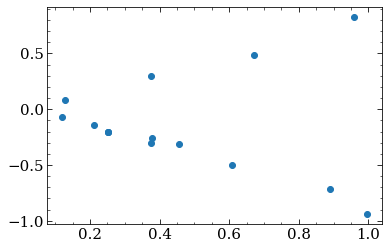

In [52]:
plt.scatter((1-sl_spearman[:, 1]), sl_spearman[:, 0])

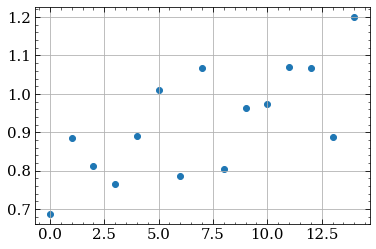

In [53]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sightlines)), chi2s)
# ax.set_ylim(0.2, 0.7)
ax.grid('on')

plt.show()

In [54]:
C0_means = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    profile_mean = np.nansum(profile * rvel) / np.nansum(profile)
    print(profile_mean)
    C0_means[i] = profile_mean.value

samples = sightlines[0].sampler.chain[:, min_walker_val:, :].reshape((-1, sightlines[0].sampler.chain.shape[-1]))
samples_v = samples[:, :sightlines[0].ndim]

distance_v = np.ones(samples_v.shape) * sightlines[0].bins[1:]

7.398562854190618 km / s
3.4834339628225757 km / s
5.42569405774534 km / s
0.4259745427798152 km / s
2.6772284184498147 km / s
5.948218157509044 km / s
6.930899300849429 km / s
5.544618909656149 km / s
0.9510323262311673 km / s
3.649101744645957 km / s
8.17674414484302 km / s
6.232093115944353 km / s
7.48699142492138 km / s
7.662701685317305 km / s
6.977859343394953 km / s


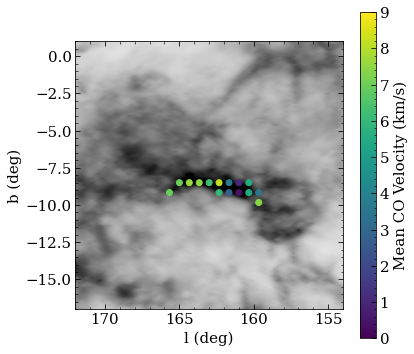

5.264743599286728


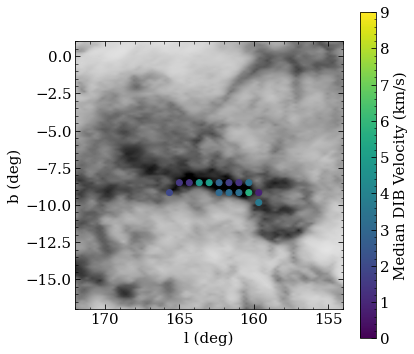

2.8828854471988024

In [55]:
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = C0_means, cmap = 'viridis',vmin = 0, vmax = 9)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Mean CO Velocity (km/s)')
plt.show()
print(np.nanmean(C0_means))

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = median_velo_sightline, cmap = 'viridis', vmin = 0, vmax = 9)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Median DIB Velocity (km/s)')
plt.show()
np.nanmean(median_velo_sightline)

In [110]:
np.nanmean([17.5, -8.5])

4.5

In [56]:
chi2_per_star = []
chi2_all = []
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]


     #= np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    # chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis], axis = 1)
    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) , axis = 1)/ np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis]

    chi2_per_star.append(chi2_per_signal)

    chi2_all.append(np.sum(chi2_per_signal))

In [57]:
chi2_per_star = []
chi2_all = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]


     #= np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    # chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis], axis = 1)
    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) , axis = 1) / np.sum(np.isnan(sl.signals)==False, axis = 1)

    chi2_per_star.append(chi2_per_signal)
    chi2_all[i] = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) ) / np.sum(np.isnan(sl.signals)==False,)


In [58]:
np.sum(np.isnan(sl.signals)==False, axis = 1)

array([80, 84, 83, 86, 86])

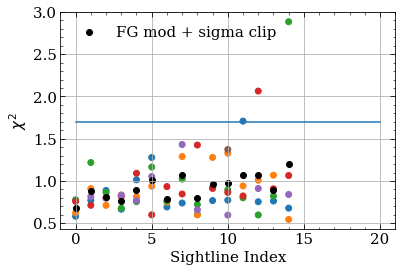

In [59]:
fig, ax = plt.subplots()
# ax.scatter(np.arange(len(sightlines)), chi2s, color = 'k')
for i in range(len(sightlines)):
    per_star_chi2s = chi2_per_star[i]
    c = ['C{}'.format(i) for i in range(len(per_star_chi2s))]
    ax.scatter(np.ones(len(per_star_chi2s)) * i, per_star_chi2s, c = c)
# ax.set_ylim(0.2, 0.7)
ax.scatter(np.arange(len(sightlines)), chi2_all, color = 'k', label = 'FG mod + sigma clip')
ax.grid('on')

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('Sightline Index')
fig.set_facecolor('white')
ax.legend()
# plt.savefig('fg_sigmaclip.png')
ax.plot((0, 20), (1.7, 1.7))
plt.show()

In [60]:
np.argsort(chi2_all)

array([ 0,  3,  6,  8,  2,  1, 13,  4,  9, 10,  5, 12,  7, 11, 14])

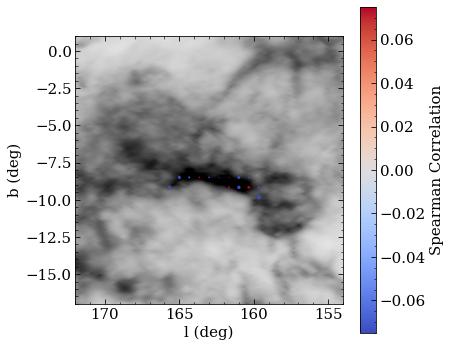

In [61]:
# 'hi''

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))

points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:, 0], s= 100 * (1-chi2_all)**2, vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()

In [67]:
def plot_velo_per_bin(sl):
    samples = sl.sampler.chain[:, -100:, :sl.ndim].reshape((-1, sl.ndim))
    fig, ax = plt.subplots()
    ax.violinplot(samples)
    plt.show()

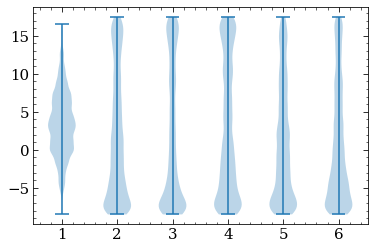

In [69]:
plot_velo_per_bin(sightlines[1])

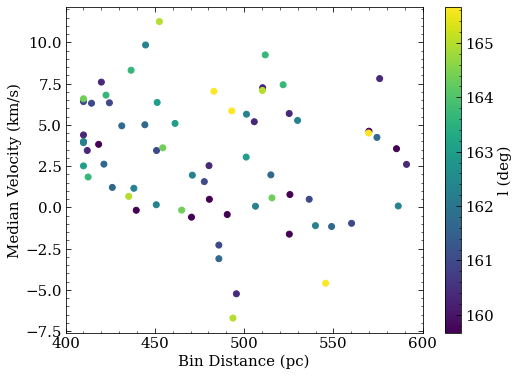

In [109]:
fig, ax = plt.subplots(figsize = (8,6))
points = ax.scatter(d_all[d_all > 401], v_all[d_all > 401], c = l_sightline[d_all > 401], )
fig.colorbar(points, label = 'l (deg)')
ax.set_xlabel('Bin Distance (pc)')
ax.set_ylabel('Median Velocity (km/s)')
ax.set_xlim(400, 600)
plt.show()